# Project 3

Import some libraries and the datasets

In [196]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, mean_squared_error,confusion_matrix, classification_report,balanced_accuracy_score, max_error, PredictionErrorDisplay,mean_absolute_error, mean_absolute_percentage_error)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict

In [197]:
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
data_index_2.set_index(['Lon','Lat'])
LPJ_GUESS_output = LPJ_GUESS_output[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
data_index_2 = data_index_2[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
# precipitation by day and statistics
Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
# maximum temperature by day and statistics
Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
# minimum temperature by day and statistics
Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
# mean temperature by day and statistics
Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
# shortwave radiation flux
Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

Text file

In [198]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [199]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59190, 83)


Lon    Lat  clay  silt  sand   orgC    CN   pH  cellfraction  \
0 -179.75  71.25  0.08  0.37  0.55  0.020  11.0  5.9         0.482   
1 -179.75  68.75  0.20  0.48  0.32  0.031  17.0  6.3         0.753   
2 -179.75  68.25  0.20  0.48  0.32  0.031  17.0  6.3         0.447   
3 -179.75  67.75  0.20  0.48  0.32  0.031  17.0  6.3         0.526   
4 -179.75  67.25  0.20  0.48  0.32  0.031  17.0  6.3         0.422   

   tmax_SpringMean  ...  VegC  LitterC  SoilC  Biome_Cmax  Biome_LAI  \
0           249.88  ...   0.0    0.000  0.000          13         13   
1           250.64  ...   0.0    0.003  0.015          13         11   
2           249.84  ...   0.0    0.006  0.022          13         11   
3           250.84  ...   0.0    0.002  0.020          13         11   
4           251.42  ...   0.0    0.003  0.016          13         11   

   Biome_obs  GFED-region  Pan_2007  ISO3   UN  
0         17           10    Russia   RUS  643  
1         17           10    Russia   RUS  643  
2         17           10    Russia   RUS  643  
3         17           10    Russia   RUS  643  
4         17           10    Russia   RUS  643  

[5 rows x 83 columns]

In [200]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

data information:
1. There are five climate variables which are daily average values during 1961-1990. They are Tswrf (Total shortwave radiation flux, W m-2), Pre (Precipitation, mm day-1), Tmp (Daily mean temperature, K), 
Tmax (Daily maximum temperature, K), and Tmin (Daily minimum temperature, K). 

2. In the file LPJ-GUESS_output BERN1.csv, the following variables are collected:
NPP: net primary productivity (kg C m-2 year-1)
SoilR: soil respiration (kg C m-2 year-1)
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)
VegC: Vegetation carbon poo (kg C m-2)l
LitterC: Litter carbon pool (kg C m-2)
SoilC: Soil carbon pool (kg C m-2)
Biome_Cmass: The biome type based on the maximum biomass (category)
Biome_LAI: The biome type based on the maximum LAI (category)
Biome_obs: The observed biome type (category)

3. legend of biome

4. soilmap_center_interpolated.dat: the texture inforamtion for each grid ce

### LPJ_Guess_output


In [201]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59190, 12)


Lon    Lat    NPP  SoilR  MaxBiomeCmax  MaxBiomeLAI   VegC  LitterC  \
0   39.75  -1.25  0.429  0.390         0.449       1.9821  1.225    0.758   
1  150.25 -34.25  0.554  0.451         6.883       3.3174  6.953    3.221   
2  -63.75  82.75  0.000  0.000         0.000       0.0000  0.000    0.003   
3   59.25  30.75  0.043  0.042         0.090       0.2146  0.127    0.084   
4   24.25  27.75  0.000  0.000         0.000       0.0000  0.000    0.000   

    SoilC  Biome_Cmax  Biome_LAI  Biome_obs  
0   5.941           8         12         12  
1  10.566           7          7          6  
2   0.002          13         13         17  
3   0.543           7         11         14  
4   0.000          13         13         17

### Pred (Precipitation, mm day-1)
 

In [202]:
print(f'shape: {Predaymean.shape}')
#Predaymean.head()

shape: (59191, 367)


In [203]:
print(f'shape: {Predaymean_statistics.shape}')
#Predaymean_statistics.head()

shape: (59191, 14)


### Tmp (Daily mean temperature, K)

In [204]:
print(f'shape: {Tmpdaymean.shape}')
#Tmpdaymean.head()

shape: (59191, 367)


In [205]:
print(f'shape: {Tmpdaymean_statistics.shape}')
#Tmpdaymean_statistics.head()

shape: (59191, 14)


### Tmax

In [206]:
print(f'shape: {Tmaxdaymean.shape}')
#Tmaxdaymean.head()

shape: (59191, 367)


In [207]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
#Tmaxdaymean_statistics.head()

shape: (59191, 14)


### Tmin

In [208]:
print(f'shape: {Tmindaymean.shape}')
#Tmindaymean.head()

shape: (59191, 367)


In [209]:
print(f'shape: {Tmindaymean_statistics.shape}')
#Tmindaymean_statistics.head()

shape: (59191, 14)


### Tswrf (Total shortwave radiation flux, W m-2)

In [210]:
print(f'shape: {Tswrfdaymean.shape}')
#Tswrfdaymean.head()

shape: (59191, 367)


In [211]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
#Tswrfdaymean_statistics.head()

shape: (59191, 14)


### County List and binome legend

In [212]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

Lon     Lat GFED-region  Pan_2007 ISO3   UN
1  -69.75  -55.25           5  Americas  CHL  152
2  -69.25  -55.25           5  Americas  CHL  152
3  -71.25  -54.75           5  Americas  CHL  152
4  -70.75  -54.75           5  Americas  CHL  152
5  -70.25  -54.75           5  Americas  CHL  152

In [213]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Some preparations

### number of samples of different biomes in different coutries

In [214]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   ##### NOT TESTED
#countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

ISO3  Biome_obs
AGO   6              3
      8            187
      9             25
      10            88
      11             7
dtype: int64

In [215]:
# Samply size for countries
countrys_sample_size.at["EGY"]

Biome_obs
14     34
16     34
17    292
dtype: int64

### Plot and table generation

In [216]:
# Names my have to be improved
def df_to_latex(df, filename = 'mytable'):  
    s = df.style.to_latex(
    column_format="rrrrrrrrrrrrrrr", position="h", position_float="centering",
    hrules=True, label="table:5",
    multirow_align="t", multicol_align="r"
    )  
        
    with open('../Table/' + filename + '.tex', 'w') as f:
        f.write(s)  
    

In [217]:
## test
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                       age=[26, 45],
                       height=[181.23, 177.65]))

df_to_latex(df, filename = 'ATable')

In [218]:
def save_plot(figure, figurename = 'my_plot'):
    figure.savefig('../plots/' + figurename + '.pdf', bbox_inches='tight')

## test
#save_plot(fig, figurename ='worldmap')

### Plot function for statistics

In [219]:
def plot_statistics(data, name_data = 'data'):
    
    obs_data = "Biome_obs"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    obs_data = "Biome_Cmax"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_Pan_2007"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'Pan_2007', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_ISO3"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'ISO3', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## scatterplot biome_Cmax and biome_LAI
    obs_data = "Biome_obs_Biome_Cmax"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_Cmax", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    
    '''
    obs_data = "Biome_obs_Biome_LAI"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_LAI", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    '''
    
    # NPP
    obs_data = "NPP"
    fig, axs = plt.subplots( 1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,  kde=True, ax=axs[0]) #stat="density", kde=True,, log_scale=True
    sns.ecdfplot(data, x="NPP", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)
    
    #"VegC"
    obs_data = "VegC"
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,   kde=True, ax=axs[0]) #stat="density", kde=True,binwidth=1,
    sns.ecdfplot(data, x="VegC", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)

## Section 2: Visualisation


In [220]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']

features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]

liste = ['Lat', 'Lon', 'UN', 'GFED-region', 'Biome_obs', 'Biome_LAI', 'Biome_Cmax']+features_weather

print(data_index_2.drop(liste, axis=1).describe())

               clay          silt          sand          orgC            CN  \
count  59190.000000  59190.000000  59190.000000  59190.000000  59190.000000   
mean       0.226426      0.280913      0.492661      0.022554     12.038250   
std        0.106557      0.109771      0.165725      0.056029      2.444517   
min        0.040000      0.050000      0.170000      0.002000      9.000000   
25%        0.170000      0.200000      0.380000      0.007000     11.000000   
50%        0.230000      0.300000      0.450000      0.013000     11.000000   
75%        0.270000      0.330000      0.570000      0.017000     13.000000   
max        0.540000      0.610000      0.900000      0.384000     23.000000   

                 pH  cellfraction           NPP         SoilR  MaxBiomeCmax  \
count  59190.000000  59190.000000  59190.000000  59190.000000  59190.000000   
mean       6.329958      0.520901      0.406856      0.347518      3.738406   
std        1.188566      0.167647      0.311654    

Countplot to count the number of data for each biom: 

In [221]:
#sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

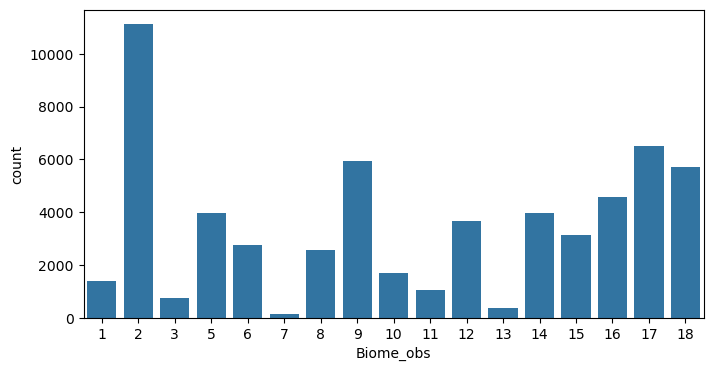

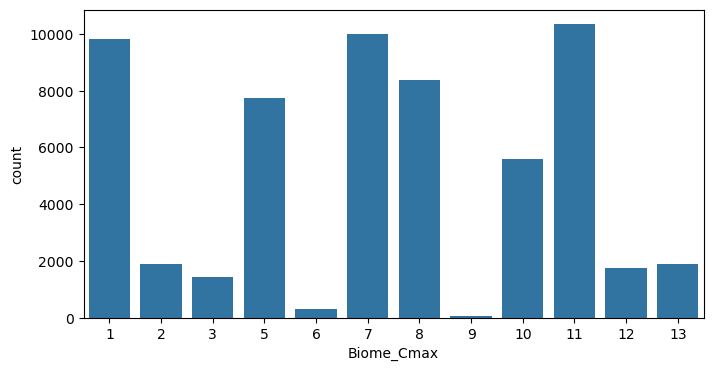

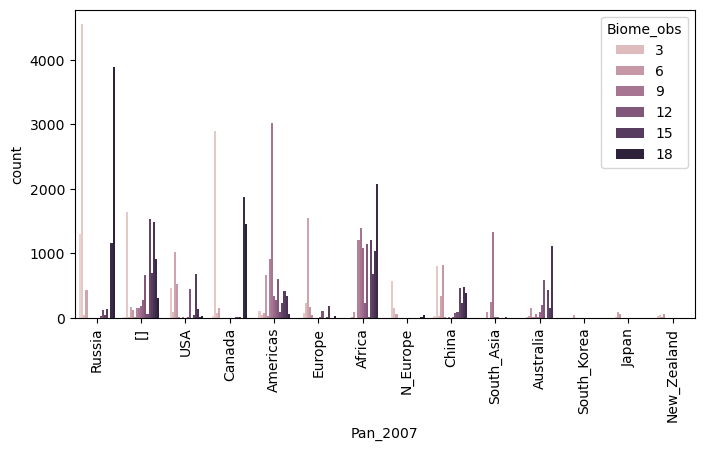

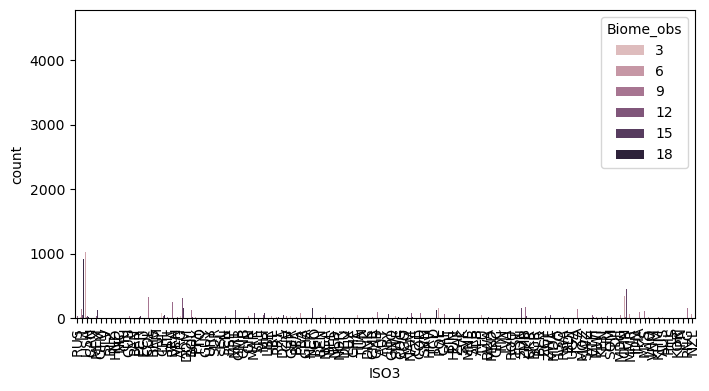

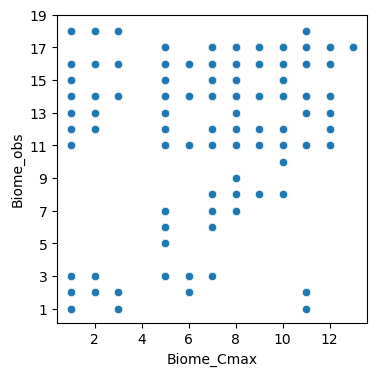

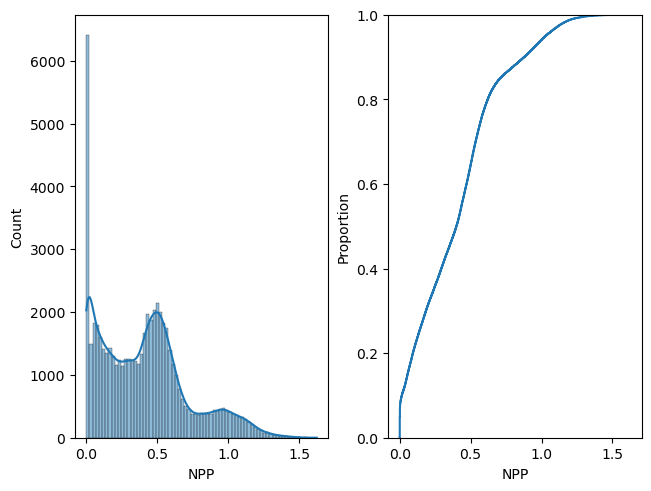

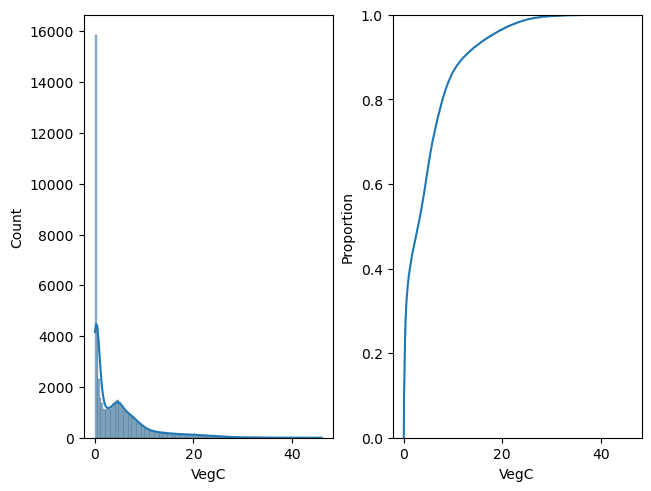

In [222]:
plot_statistics(data_index_2)

Biome with index 4?

In [223]:
data_index_2.loc[data_index_2['Biome_obs'] == 4]

Empty DataFrame
Columns: [Lon, Lat, clay, silt, sand, orgC, CN, pH, cellfraction, tmax_SpringMean, tmax_SpringMedian, tmax_SpringStd, tmax_SummerMean, tmax_SummerMedian, tmax_SummerStd, tmax_FallMean, tmax_FallMedian, tmax_FallStd, tmax_WinterMean, tmax_WinterMedian, tmax_WinterStd, tswrf_SpringMean, tswrf_SpringMedian, tswrf_SpringStd, tswrf_SummerMean, tswrf_SummerMedian, tswrf_SummerStd, tswrf_FallMean, tswrf_FallMedian, tswrf_FallStd, tswrf_WinterMean, tswrf_WinterMedian, tswrf_WinterStd, tmin_SpringMean, tmin_SpringMedian, tmin_SpringStd, tmin_SummerMean, tmin_SummerMedian, tmin_SummerStd, tmin_FallMean, tmin_FallMedian, tmin_FallStd, tmin_WinterMean, tmin_WinterMedian, tmin_WinterStd, tmp_SpringMean, tmp_SpringMedian, tmp_SpringStd, tmp_SummerMean, tmp_SummerMedian, tmp_SummerStd, tmp_FallMean, tmp_FallMedian, tmp_FallStd, tmp_WinterMean, tmp_WinterMedian, tmp_WinterStd, Pre_SpringMean, Pre_SpringMedian, Pre_SpringStd, Pre_SummerMean, Pre_SummerMedian, Pre_SummerStd, Pre_FallMean, Pre_FallMedian, Pre_FallStd, Pre_WinterMean, Pre_WinterMedian, Pre_WinterStd, NPP, SoilR, MaxBiomeCmax, MaxBiomeLAI, VegC, LitterC, SoilC, Biome_Cmax, Biome_LAI, Biome_obs, GFED-region, Pan_2007, ISO3, UN]
Index: []

[0 rows x 83 columns]

# Functions for Classifiaction and Regression

### Generate test and train sets

In [224]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(region_train, region_test, \
                     drop_columns=[], use_columns=None, \
                        objective='Biome_obs', objective_list=None, continuous_Y=False,
                        objective_test=None):
      
      drop_columns = drop_columns.copy() + [objective] # we would not want our objective to appear in the training data
      if not objective_test: objective_test = objective

      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      if not continuous_Y:
            if not objective_list: objective_list=list(data_index_2.loc[region_train][objective].drop_duplicates())
            relevant_data_train = data_index_2.loc[data_index_2[objective].isin(objective_list)] # restrict to given biomes
            # in case we want to use LPJ_guess output, write LPJ_ before the objective_list
            if re.search('LPJ_',objective_test):
                  objective_test = objective_test[4:]
                  relevant_data_test = data_index_2.loc[LPJ_GUESS_output[objective_test].isin(objective_list)] # restrict to given biomes
                  relevant_data_test[objective_test] = LPJ_GUESS_output.loc[LPJ_GUESS_output[objective_test].isin(objective_list)][objective_test] # restrict to given biomes
            else:
                  relevant_data_test = data_index_2.loc[data_index_2[objective_test].isin(objective_list)] # restrict to given biomes
      else:
            relevant_data_train = data_index_2
            relevant_data_test = data_index_2
            if re.search('LPJ_',objective_test):
                  objective_test = objective_test[4:]
                  relevant_data_test[objective_test] = LPJ_GUESS_output[objective_test]

                  
      relevant_data_train = relevant_data_train.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data_test.loc[region_test] # restrict to test country

      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective]
      Y_test = relevant_data_test[objective_test]

      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")
      

      return X_train, X_test, Y_train, Y_test, feature_names

### Plot Feature importance (Permutation importance vs. purity importance)

Important Notes
- The more accurate model is, the more trustworthy computed importances are.
- The computed importances describe how important features are for the machine learning model. It is an approximation of how important features are in the data.


In [273]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

def plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, feature_imp):

    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 16))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features"
    )
    plot_permutation_importance(clf, X_test, Y_test, ax3)
    ax3.set_xlabel("Decrease in accuracy score")
    _ = fig.tight_layout()
    return fig

def clustering(clf, X_train, X_test,  Y_train, Y_test):
    
    
    fig, (ax1) = plt.subplots( figsize=(8, 12))
    corr = spearmanr(X_train).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    #ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    #ax2.set_xticks(dendro_idx)
    #ax2.set_yticks(dendro_idx)
    #ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    #ax2.set_yticklabels(dendro["ivl"])
    #_ = fig.tight_layout()
    
    cluster_ids = hierarchy.fcluster(dist_linkage, 0.6, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_train.columns[selected_features]
    selected_features_names = selected_features_names.tolist()
    
    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = clf
    clf_sel.fit(X_train_sel, Y_train)
    print(
        "Baseline accuracy on test data with features removed:"
        f" {accuracy_score(Y_test, clf.predict(X_test_sel)):.4}"
        "Baseline balanced accuracy on test data with features removed:"
        f" {balanced_accuracy_score(Y_test, clf.predict(X_test_sel)):.4}"
    )
    
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_permutation_importance(clf_sel, X_test_sel, Y_test, ax)
    ax.set_title("Permutation Importances on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9793 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9603
Balanced accuracy of RandomForestClassifier on train data: 0.6615


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          24    94   0    0   0   0   0   0     0     2
2           4  2790  54   37   1   5   1   1     0    24
3           0     2   2    2   0   0   0   0     0     0
5           0     1  10  115   0   0   0   0     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0   9   0   0     0     0
14          0     0   0    0   0   2   8   0     0     0
15          0     1   0    0   0   0   0   4     0     0
17          0     0   0    0   0   0   0   0  1869     5
18          6     3   0    0   0   2   0   0     1  1418

precision    recall  f1-score      support
1              0.200000  0.705882  0.311688    34.000000
2              0.956462  0.965064  0.960744  2891.000000
3              0.333333  0.030303  0.055556    66.000000
5              0.912698  0.746753  0.821429   154.000000
12                  NaN  0.000000       NaN     1.000000
13             1.000000  0.500000  0.666667    18.000000
14             0.800000  0.888889  0.842105     9.000000
15             0.800000  0.800000  0.800000     5.000000
17             0.997332  0.999465  0.998397  1870.000000
18             0.991608  0.978606  0.985064  1449.000000
accuracy       0.960289  0.960289  0.960289     0.960289
macro avg      0.776826  0.661496  0.715739  6497.000000
weighted avg   0.964523  0.960289  0.960008  6497.000000

---
 The feature importance

importance
VegC                0.150247
LitterC             0.077989
NPP                 0.067365
tmp_WinterMean      0.042188
tmp_WinterMedian    0.039423
...                      ...
clay                0.000559
sand                0.000473
orgC                0.000342
CN                  0.000333
GFED-region         0.000052

[73 rows x 1 columns]

Baseline accuracy on test data with features removed: 0.9207Baseline balanced accuracy on test data with features removed: 0.4664


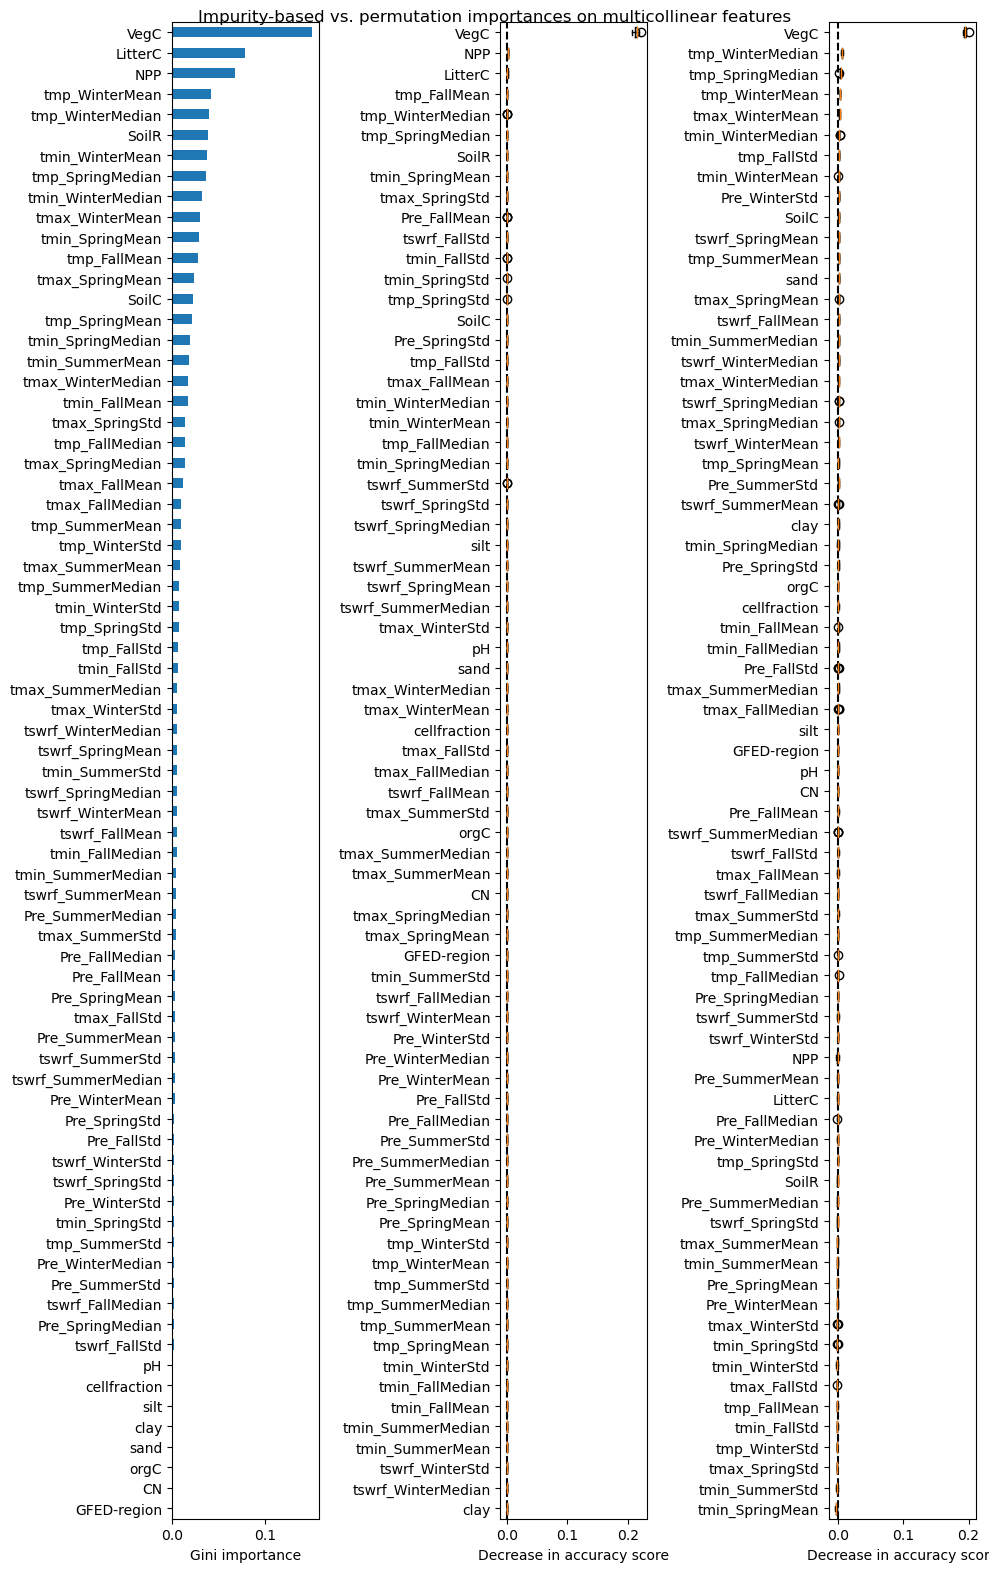

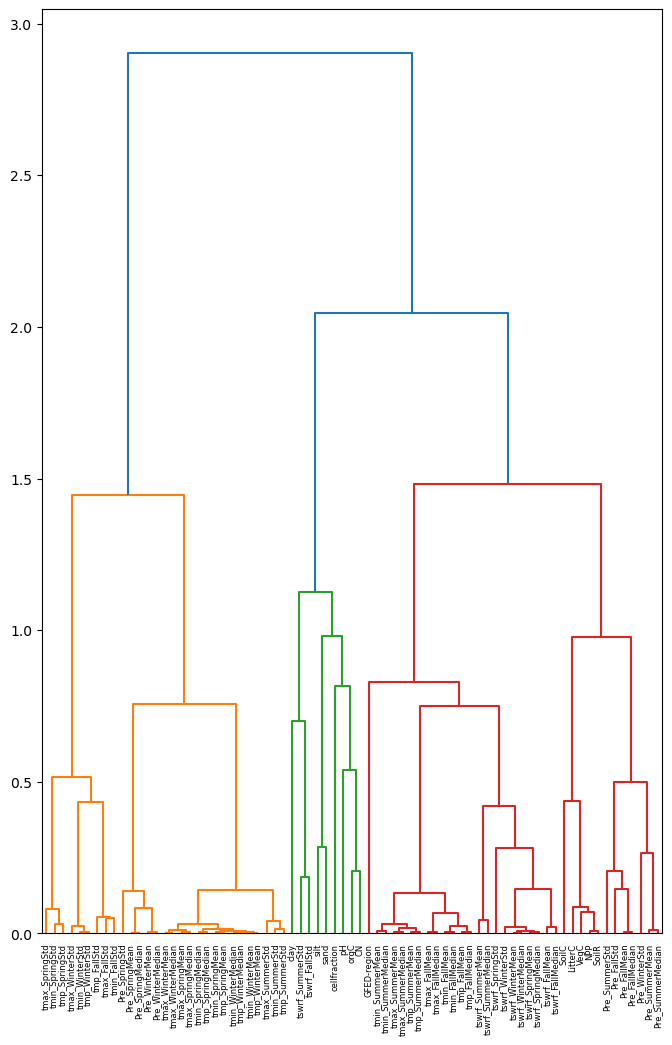

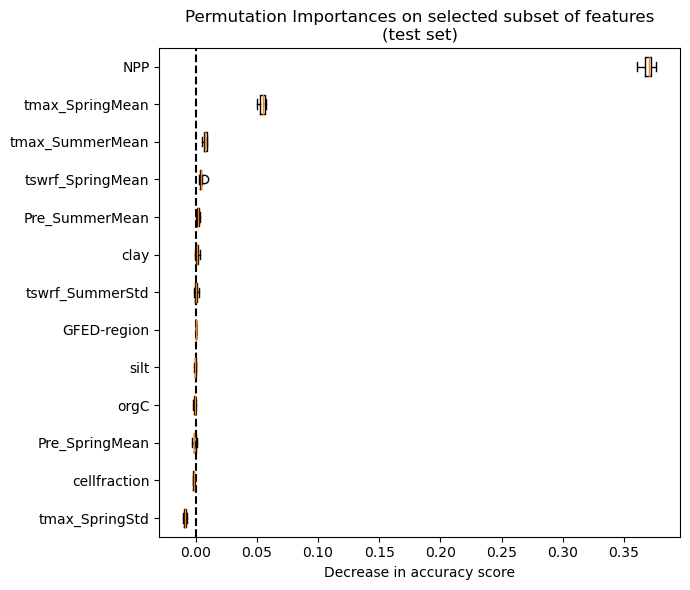

---

In [274]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=False, future_plots = True, experiment_name = "s4_basic")

In [256]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True)

length of training data: 11696
length of testing data: 6497
Max Depth:  2
Max Trees:  72
Min Leafs:  2
Max CV:  0.8333333333333334
Accuracy of RandomForestClassifier on train data: 0.8761
Balanced accuracy of RandomForestClassifier on train data: 0.3413
Accuracy RandomForestClassifier on cross validation: 0.8725 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.8675
Balanced accuracy of RandomForestClassifier on train data: 0.3222


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          20    41   0    0   0   0   0   0     0     1
2           9  2840  66  154   1  18   9   5   162   373
3           0     0   0    0   0   0   0   0     0     0
5           0     0   0    0   0   0   0   0     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0   0   0   0     0     0
14          0     0   0    0   0   0   0   0     0     0
15          0     0   0    0   0   0   0   0     0     0
17          0     0   0    0   0   0   0   0  1704     3
18          5    10   0    0   0   0   0   0     4  1072

precision    recall  f1-score      support
1              0.322581  0.588235  0.416667    34.000000
2              0.780863  0.982359  0.870098  2891.000000
3                   NaN  0.000000       NaN    66.000000
5                   NaN  0.000000       NaN   154.000000
12                  NaN  0.000000       NaN     1.000000
13                  NaN  0.000000       NaN    18.000000
14                  NaN  0.000000       NaN     9.000000
15                  NaN  0.000000       NaN     5.000000
17             0.998243  0.911230  0.952754  1870.000000
18             0.982585  0.739821  0.844094  1449.000000
accuracy       0.867477  0.867477  0.867477     0.867477
macro avg      0.771068  0.322164  0.770903  6497.000000
weighted avg   0.890282  0.867477  0.886349  6497.000000

---
 The feature importance

importance
VegC                 0.143379
LitterC              0.081002
tmin_WinterMedian    0.069031
tmp_WinterMedian     0.067427
tmp_WinterMean       0.065554
...                       ...
tswrf_SummerStd      0.000000
tswrf_FallMedian     0.000000
tswrf_FallStd        0.000000
tmin_SpringStd       0.000000
GFED-region          0.000000

[73 rows x 1 columns]

---

### Classification

In [ ]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, future_plots=False, experiment_name=None):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning==4: # for testing parameters manually
        clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100, min_samples_leaf=1)
    elif hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        # TODO: improve on this
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 6 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(5, 15, fineness).astype('int'), # (5,15)
                'n_estimators': np.linspace(50, 150, fineness).astype('int'), # (50,150), (10, 40)CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    balance_score_rfc_train = balanced_accuracy_score(Y_train, clf.predict(X_train))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_train))
    
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    balance_score_rfc_test = balanced_accuracy_score(Y_test, clf.predict(X_test))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    conf_table = confusion_table(clf.predict(X_test),
                            Y_test)
    display(conf_table)
    if experiment_name:
        df_to_latex(conf_table, f'../table/{experiment_name}_confTable')
    
    classreport = classification_report(Y_test, clf.predict(X_test), zero_division = np.nan, output_dict=True, digit = 2)
    classreport = pd.DataFrame(classreport).transpose()
    display(classreport)
    if experiment_name:
        df_to_latex(classreport, f'../table/{experiment_name}_classreport')
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    display(feature_imp)
    if experiment_name:
        df_to_latex(feature_imp, f'../table/{experiment_name}_featureImportance')
    
    if future_plots:
        # Plot Impurity-based vs. Permutation importance
        plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, feature_imp)
        
        clustering(clf, X_train, X_test, Y_train, Y_test)
        
    display(Markdown('---'))

### Regression

In [227]:
def regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, future_plots=False, experiment_name=None):
    reg = RandomForestRegressor()
    reg.fit(X_train, Y_train)

    score_reg_train = reg.score(X_train, Y_train)
    #Return the coefficient of determination of the prediction (R^2 score)
    
    print('Accuracy of RandomForestRegressor on train data: {:.4f}'.format(score_reg_train))
    # The following takes way to long for large training sets
    # kfold = skm.KFold(3, random_state=1, shuffle=True)
    # scores_reg_val = cross_val_score(reg, X_train, Y_train, cv=kfold)
    # print("Accuracy RandomForestRegressor on cross validation: %0.4f ( %0.2f)" % (scores_reg_val.mean(), scores_reg_val.std()))
    score_reg_test = reg.score(X_test, Y_test)
    print('Accuracy of RandomForestRegressor on test data: {:.4f}'.format(score_reg_test))

    # MSE
    Y_hat = reg.predict(X_test)
    mse = np.mean((Y_test - Y_hat)**2)
    print(f'MSE for training data {mse}')

    mse2 = mean_squared_error(Y_test,Y_hat)
    print(f'MSE (with sktfct) for test  data {mse2}')

    # SQRT(MSE)
    sqrtmse = np.sqrt(mse)
    print(f'sqrt(MSE) for test data {sqrtmse}')

    # maximum Error
    max_err = max_error(Y_test, Y_hat)
    print(f'max error for test data {max_err}')

    # mean absolute error
    mean_abs_err = mean_absolute_error(Y_test, Y_hat)
    print(f'mean abs error for test data {mean_abs_err}')

    #PredictionErrorDisplay(Y_test, Y_hat)
    
    
    
    fig, ax = subplots()
    ax.scatter(Y_hat, Y_test)
    ax.set_xlabel('predicted sample $\hat{Y}$')
    ax.set_ylabel('exact sample $Y_{test}$')
    maxval = max([np.max(Y_test),np.max(Y_hat)])
    ax.plot([0,maxval],[0,maxval],color='red')

    fig, ax = plt.subplots()
    ax.hist(Y_test-Y_hat, bins=50, density=True)
    ax.set_xlabel('residue $Y_{test}-\hat{Y}$')
    ax.set_ylabel('Share of samples')
    

about R2 score - which is the accuracz in the regression case: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion. (Wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination)

### Run model 
continuous_Y = True gives regression, else classification



In [228]:

# run the training data, test data and the model
def model_run(region_train, region_test, objective='Biome_obs', objective_list=None, \
                drop_columns=[], use_columns=None, \
                hyperparameter_tuning=False, continuous_Y=False, objective_test=None, \
                    future_plots=False, experiment_name=None):
    X_train, X_test, Y_train, Y_test, feature_names = model_create_XY(region_train, \
                        region_test, drop_columns, use_columns, objective, \
                              objective_list, continuous_Y, objective_test)
    if continuous_Y:
        regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, future_plots, experiment_name)
    else:
        model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, future_plots, experiment_name)

## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [229]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

[]


Empty DataFrame
Columns: [Lon, Lat, clay, silt, sand, orgC, CN, pH, cellfraction, tmax_SpringMean, tmax_SpringMedian, tmax_SpringStd, tmax_SummerMean, tmax_SummerMedian, tmax_SummerStd, tmax_FallMean, tmax_FallMedian, tmax_FallStd, tmax_WinterMean, tmax_WinterMedian, tmax_WinterStd, tswrf_SpringMean, tswrf_SpringMedian, tswrf_SpringStd, tswrf_SummerMean, tswrf_SummerMedian, tswrf_SummerStd, tswrf_FallMean, tswrf_FallMedian, tswrf_FallStd, tswrf_WinterMean, tswrf_WinterMedian, tswrf_WinterStd, tmin_SpringMean, tmin_SpringMedian, tmin_SpringStd, tmin_SummerMean, tmin_SummerMedian, tmin_SummerStd, tmin_FallMean, tmin_FallMedian, tmin_FallStd, tmin_WinterMean, tmin_WinterMedian, tmin_WinterStd, tmp_SpringMean, tmp_SpringMedian, tmp_SpringStd, tmp_SummerMean, tmp_SummerMedian, tmp_SummerStd, tmp_FallMean, tmp_FallMedian, tmp_FallStd, tmp_WinterMean, tmp_WinterMedian, tmp_WinterStd, Pre_SpringMean, Pre_SpringMedian, Pre_SpringStd, Pre_SummerMean, Pre_SummerMedian, Pre_SummerStd, Pre_FallMean, Pre_FallMedian, Pre_FallStd, Pre_WinterMean, Pre_WinterMedian, Pre_WinterStd, NPP, SoilR, MaxBiomeCmax, MaxBiomeLAI, VegC, LitterC, SoilC, Biome_Cmax, Biome_LAI, Biome_obs, GFED-region, Pan_2007, ISO3, UN]
Index: []

[0 rows x 83 columns]

Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [230]:
biome_list_3 = [17,16] # our chosen biomes

Countplot: 

In [231]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

In [232]:
#plot_statistics(relevant_data, name_data = 'Section3Biome17_and_16')

Thus we choose Egypt to train and China as test.

In [233]:
region_train_3 = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test_3 = data_index_2['ISO3'] == 'CHN' # china is the chosen one, alternatively LBY (libya)

In [234]:
# plot the data
data1 = relevant_data.loc[region_train_3] 
data2 = relevant_data.loc[region_test_3]

data = pd.concat([data1,data2])
#plot_statistics(data, name_data = 'Section3EGY-CHN')

Here the action starts.

In [235]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3, future_plots=False, experiment_name='s3_basic')

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850
Balanced accuracy of RandomForestClassifier on train data: 0.9835


---
 The confusion table

Truth       16   17
Predicted          
16         477   12
17           1  377

precision    recall  f1-score     support
16             0.975460  0.997908  0.986556  478.000000
17             0.997354  0.969152  0.983051  389.000000
accuracy       0.985006  0.985006  0.985006    0.985006
macro avg      0.986407  0.983530  0.984804  867.000000
weighted avg   0.985284  0.985006  0.984984  867.000000

---
 The feature importance

importance
SoilR               0.119342
VegC                0.096762
tmp_FallMean        0.069502
Pre_SpringMedian    0.050491
NPP                 0.046478
...                      ...
CN                  0.000878
silt                0.000679
GFED-region         0.000266
orgC                0.000218
pH                  0.000000

[73 rows x 1 columns]

---

And now run the model whilst removing the medians

In [236]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
print(f'We dropped the features: {features_median}')

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_median, experiment_name='s3_dropMedian')

We dropped the features: ['tmax_SpringMedian', 'tmax_SummerMedian', 'tmax_FallMedian', 'tmax_WinterMedian', 'tswrf_SpringMedian', 'tswrf_SummerMedian', 'tswrf_FallMedian', 'tswrf_WinterMedian', 'tmin_SpringMedian', 'tmin_SummerMedian', 'tmin_FallMedian', 'tmin_WinterMedian', 'tmp_SpringMedian', 'tmp_SummerMedian', 'tmp_FallMedian', 'tmp_WinterMedian', 'Pre_SpringMedian', 'Pre_SummerMedian', 'Pre_FallMedian', 'Pre_WinterMedian']
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9919
Balanced accuracy of RandomForestClassifier on train data: 0.9912


---
 The confusion table

Truth       16   17
Predicted          
16         477    6
17           1  383

precision    recall  f1-score     support
16             0.987578  0.997908  0.992716  478.000000
17             0.997396  0.984576  0.990944  389.000000
accuracy       0.991926  0.991926  0.991926    0.991926
macro avg      0.992487  0.991242  0.991830  867.000000
weighted avg   0.991983  0.991926  0.991921  867.000000

---
 The feature importance

importance
SoilR               0.143831
VegC                0.087635
NPP                 0.069610
Pre_SpringMean      0.064470
tmp_FallMean        0.058189
Pre_WinterMean      0.048003
Pre_WinterStd       0.042217
tmin_FallMean       0.039417
tmp_SummerMean      0.034553
tswrf_WinterMean    0.031324
tswrf_SpringMean    0.030389
tmin_FallStd        0.026393
Pre_SpringStd       0.022128
tmax_FallMean       0.021406
SoilC               0.021023
LitterC             0.018860
tmp_SpringStd       0.016631
tmp_WinterStd       0.014224
tmp_SpringMean      0.013971
tmax_FallStd        0.011693
tmax_SummerMean     0.011104
tmax_SpringStd      0.010728
tmin_SpringStd      0.010562
tswrf_SpringStd     0.010390
tmax_WinterStd      0.009998
Pre_FallMean        0.009406
tmin_SpringMean     0.009334
tmin_WinterMean     0.008665
tmin_WinterStd      0.008610
tmp_SummerStd       0.008354
tmp_WinterMean      0.008252
Pre_FallStd         0.008065
cellfraction        0.007624
Pre_SummerStd       0.006774
tmp_FallStd         0.006398
tmin_SummerMean     0.006211
Pre_SummerMean      0.005303
tswrf_FallMean      0.004694
tswrf_WinterStd     0.004499
tmax_WinterMean     0.004142
tmin_SummerStd      0.003516
silt                0.003231
tswrf_FallStd       0.002975
tswrf_SummerMean    0.002923
tswrf_SummerStd     0.002494
tmax_SpringMean     0.002228
pH                  0.001612
sand                0.001608
clay                0.001552
orgC                0.001115
CN                  0.000758
GFED-region         0.000520
tmax_SummerStd      0.000392

---

Let's see how important the weather is.

In [237]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
print(f'We dropped the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_weather, experiment_name='s3_dropWeather')

We dropped the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9663 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9931
Balanced accuracy of RandomForestClassifier on train data: 0.9925


---
 The confusion table

Truth       16   17
Predicted          
16         477    5
17           1  384

precision    recall  f1-score    support
16             0.989627  0.997908  0.993750  478.00000
17             0.997403  0.987147  0.992248  389.00000
accuracy       0.993080  0.993080  0.993080    0.99308
macro avg      0.993515  0.992527  0.992999  867.00000
weighted avg   0.993115  0.993080  0.993076  867.00000

---
 The feature importance

importance
SoilR           0.318373
VegC            0.194957
NPP             0.183975
SoilC           0.078456
LitterC         0.076630
clay            0.036141
cellfraction    0.027651
sand            0.025204
pH              0.017084
silt            0.014798
GFED-region     0.012302
CN              0.007773
orgC            0.006657

---

What effect do the different seasons have?

In [238]:
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]

for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
               drop_columns=features_seasons[i], experiment_name=f's3_drop_{season}')

Dropping season Fall
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9400
Balanced accuracy of RandomForestClassifier on train data: 0.9334


---
 The confusion table

Truth       16   17
Predicted          
16         477   51
17           1  338

precision    recall  f1-score     support
16             0.903409  0.997908  0.948310  478.000000
17             0.997050  0.868895  0.928571  389.000000
accuracy       0.940023  0.940023  0.940023    0.940023
macro avg      0.950230  0.933401  0.938441  867.000000
weighted avg   0.945423  0.940023  0.939454  867.000000

---
 The feature importance

importance
SoilR                 0.113081
NPP                   0.075368
VegC                  0.074045
Pre_WinterMean        0.069700
Pre_WinterMedian      0.064192
Pre_SpringMean        0.053945
Pre_SpringMedian      0.052056
Pre_WinterStd         0.037603
tswrf_SpringMean      0.033213
tswrf_WinterMean      0.031864
tmin_SummerMean       0.027759
tmp_SummerMedian      0.027505
SoilC                 0.026387
tswrf_SpringMedian    0.024045
tmp_SummerMean        0.016395
tmp_SpringStd         0.016352
tmax_SummerMedian     0.015090
tmax_SummerMean       0.014396
Pre_SpringStd         0.012915
tmin_SummerMedian     0.012103
tmax_SpringStd        0.011359
tswrf_WinterMedian    0.011305
tmp_SpringMedian      0.010811
Pre_SummerMedian      0.010547
LitterC               0.010413
tmp_SummerStd         0.009326
tmp_WinterMedian      0.009068
tmp_SpringMean        0.008492
tmax_WinterMedian     0.007650
tswrf_SpringStd       0.007016
Pre_SummerStd         0.006976
tmin_WinterStd        0.006901
tmp_WinterStd         0.006483
tmp_WinterMean        0.005901
tmax_WinterMean       0.005841
tmin_SpringMean       0.005632
tswrf_WinterStd       0.005489
Pre_SummerMean        0.005177
tmax_WinterStd        0.004852
tmax_SpringMedian     0.004681
tmin_WinterMedian     0.004554
tmin_SpringMedian     0.003966
cellfraction          0.003879
tmax_SummerStd        0.003851
tswrf_SummerMean      0.003697
tmax_SpringMean       0.003493
CN                    0.003377
clay                  0.002855
tmin_WinterMean       0.002707
tswrf_SummerMedian    0.002548
tmin_SpringStd        0.002255
silt                  0.002191
tmin_SummerStd        0.002119
sand                  0.002055
tswrf_SummerStd       0.002030
orgC                  0.001738
pH                    0.000749
GFED-region           0.000000

---

Dropping season Summer
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9308
Balanced accuracy of RandomForestClassifier on train data: 0.9234


---
 The confusion table

Truth       16   17
Predicted          
16         476   58
17           2  331

precision    recall  f1-score     support
16             0.891386  0.995816  0.940711  478.000000
17             0.993994  0.850900  0.916898  389.000000
accuracy       0.930796  0.930796  0.930796    0.930796
macro avg      0.942690  0.923358  0.928804  867.000000
weighted avg   0.937423  0.930796  0.930027  867.000000

---
 The feature importance

importance
SoilR                 0.115421
NPP                   0.078965
Pre_WinterMean        0.078209
VegC                  0.073566
Pre_WinterMedian      0.066785
Pre_SpringMean        0.053857
Pre_SpringMedian      0.046223
Pre_WinterStd         0.032143
tswrf_SpringMean      0.029890
tmin_FallMedian       0.028633
SoilC                 0.024348
tmin_FallMean         0.024074
tmp_SpringStd         0.023665
tmp_FallMedian        0.023598
tswrf_SpringMedian    0.022685
tswrf_WinterMean      0.021668
tmax_FallMean         0.017828
tmp_FallMean          0.017489
tmin_FallStd          0.014344
tmax_SpringStd        0.013958
Pre_SpringStd         0.012407
tswrf_WinterMedian    0.011638
tmax_FallStd          0.010740
tmax_FallMedian       0.010355
tmp_WinterMedian      0.010118
LitterC               0.009706
tswrf_FallMedian      0.007916
Pre_FallStd           0.006687
tswrf_SpringStd       0.006661
tmax_WinterMedian     0.006301
tmax_WinterMean       0.006286
tmp_SpringMedian      0.006183
tmax_WinterStd        0.006135
Pre_FallMedian        0.005752
tmp_SpringMean        0.005399
tswrf_WinterStd       0.004916
Pre_FallMean          0.004845
tmin_SpringMean       0.004711
tmin_WinterMedian     0.004683
tmin_SpringMedian     0.004385
tmp_WinterMean        0.004273
tmax_SpringMean       0.004051
tswrf_FallStd         0.003856
tmin_SpringStd        0.003709
silt                  0.003459
tswrf_FallMean        0.003453
tmax_SpringMedian     0.003394
tmp_WinterStd         0.003360
cellfraction          0.002974
clay                  0.002799
tmin_WinterStd        0.002647
tmin_WinterMean       0.002566
orgC                  0.002563
tmp_FallStd           0.001304
sand                  0.001277
CN                    0.000712
pH                    0.000275
GFED-region           0.000156

---

Dropping season Winter
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9769
Balanced accuracy of RandomForestClassifier on train data: 0.9745


---
 The confusion table

Truth       16   17
Predicted          
16         477   19
17           1  370

precision    recall  f1-score     support
16             0.961694  0.997908  0.979466  478.000000
17             0.997305  0.951157  0.973684  389.000000
accuracy       0.976932  0.976932  0.976932    0.976932
macro avg      0.979499  0.974532  0.976575  867.000000
weighted avg   0.977671  0.976932  0.976872  867.000000

---
 The feature importance

importance
SoilR                 0.110845
VegC                  0.089777
NPP                   0.075379
Pre_SpringMean        0.052803
Pre_SpringMedian      0.051670
tswrf_SpringMean      0.040491
tmp_SummerMean        0.036545
tmp_SummerMedian      0.034106
tmp_FallMedian        0.033158
tmin_SummerMean       0.031910
tmin_FallMedian       0.031386
tmp_SpringStd         0.027957
SoilC                 0.021461
tmp_FallMean          0.021321
tmax_SummerMedian     0.019921
tmin_FallMean         0.019279
tmax_FallMedian       0.017902
tmin_FallStd          0.017875
tswrf_SpringMedian    0.017196
Pre_SpringStd         0.014321
tmin_SummerMedian     0.013899
tmax_FallStd          0.012815
tmp_SummerStd         0.012620
tmp_SpringMedian      0.012582
LitterC               0.011916
tmin_SpringMean       0.011740
tmp_SpringMean        0.011394
tmax_SpringStd        0.011156
Pre_SummerMedian      0.010983
tmax_SummerMean       0.008647
Pre_SummerStd         0.008260
tswrf_SummerMedian    0.007972
Pre_FallMedian        0.007839
tmin_SpringStd        0.007268
tmax_FallMean         0.006791
tmp_FallStd           0.006659
cellfraction          0.006474
tmax_SpringMedian     0.006261
tswrf_FallMean        0.005900
Pre_SummerMean        0.005727
tswrf_SummerMean      0.005156
tmax_SpringMean       0.004716
tswrf_SpringStd       0.004568
clay                  0.003580
tmin_SummerStd        0.003562
tswrf_FallStd         0.003447
tswrf_SummerStd       0.003386
Pre_FallStd           0.003318
tmax_SummerStd        0.003185
tmin_SpringMedian     0.002245
tswrf_FallMedian      0.002144
CN                    0.002112
silt                  0.001737
sand                  0.001289
Pre_FallMean          0.001201
orgC                  0.001116
GFED-region           0.000564
pH                    0.000467

---

Dropping season Spring
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9781
Balanced accuracy of RandomForestClassifier on train data: 0.9758


---
 The confusion table

Truth       16   17
Predicted          
16         477   18
17           1  371

precision    recall  f1-score     support
16             0.963636  0.997908  0.980473  478.000000
17             0.997312  0.953728  0.975033  389.000000
accuracy       0.978085  0.978085  0.978085    0.978085
macro avg      0.980474  0.975818  0.977753  867.000000
weighted avg   0.978746  0.978085  0.978032  867.000000

---
 The feature importance

importance
SoilR                 0.120728
Pre_WinterMean        0.086957
VegC                  0.081312
NPP                   0.076829
Pre_WinterMedian      0.063743
Pre_WinterStd         0.045300
tmp_FallMedian        0.037575
tmin_FallStd          0.028709
tswrf_WinterMean      0.026362
SoilC                 0.025530
tmin_FallMedian       0.024292
tmp_SummerMedian      0.024099
tmp_SummerMean        0.021887
tmp_FallMean          0.021862
tmin_FallMean         0.019400
tmin_SummerMedian     0.017875
Pre_SummerMedian      0.016847
tmax_SummerMean       0.015783
tmp_WinterStd         0.014978
LitterC               0.013822
tmax_FallMean         0.013572
tswrf_WinterMedian    0.010870
tmax_FallStd          0.010869
tmax_FallMedian       0.010620
Pre_FallMedian        0.010605
Pre_SummerStd         0.010513
tmp_SummerStd         0.010340
tmax_SummerMedian     0.010066
tmp_WinterMedian      0.009091
tmp_WinterMean        0.007452
tmin_SummerStd        0.006614
tswrf_FallMedian      0.006553
tswrf_SummerStd       0.006505
tswrf_WinterStd       0.006462
tswrf_SummerMean      0.006096
tmin_WinterMedian     0.006073
tmax_WinterMean       0.006064
tmin_SummerMean       0.005881
Pre_FallStd           0.005171
tmax_WinterStd        0.005120
tmp_FallStd           0.004639
tmin_WinterMean       0.004343
tmin_WinterStd        0.004342
tswrf_SummerMedian    0.004292
Pre_FallMean          0.004140
Pre_SummerMean        0.004114
tmax_SummerStd        0.003843
tswrf_FallStd         0.003817
clay                  0.003790
silt                  0.003482
cellfraction          0.003202
tmax_WinterMedian     0.002914
tswrf_FallMean        0.001676
orgC                  0.001648
sand                  0.001037
CN                    0.000291
pH                    0.000000
GFED-region           0.000000

---

Dropping autumn or summer had the biggest impact. Dropping spring and winter the least. Dropping the seasons does negatively effect our model. Now we test the different weather parameters.

In [239]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']
features_weather_params = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(weather_param,feature_name)] for weather_param in weather_params]

for i,weather_param in enumerate(weather_params):
    print(f'Dropping the weather parameters {weather_param}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
              drop_columns=features_weather_params[i], experiment_name=f'drop_{weather_params}')

Dropping the weather parameters pre
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850
Balanced accuracy of RandomForestClassifier on train data: 0.9835


---
 The confusion table

Truth       16   17
Predicted          
16         477   12
17           1  377

OSError: [Errno 22] Invalid argument: "../Table/../table/drop_['pre', 'tmp|tmin|tmax', 'tswrf']_confTable.tex"

None of the weather parameters has a striking impact on performance. Now lets see if the model works only with weather data.

In [240]:
print(f'We only use the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
          use_columns=features_weather, experiment_name='s3_useWeather')

We only use the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMea

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5502
Balanced accuracy of RandomForestClassifier on train data: 0.4990


---
 The confusion table

Truth       16   17
Predicted          
16         477  389
17           1    0

precision    recall  f1-score     support
16             0.550808  0.997908  0.709821  478.000000
17             0.000000  0.000000       NaN  389.000000
accuracy       0.550173  0.550173  0.550173    0.550173
macro avg      0.275404  0.498954  0.709821  867.000000
weighted avg   0.303675  0.550173  0.709821  867.000000

---
 The feature importance

importance
Pre_SpringMedian      0.071748
Pre_WinterMean        0.066330
tmin_FallMedian       0.055103
Pre_SpringMean        0.054281
Pre_WinterStd         0.053840
tmp_FallMean          0.048556
tmp_FallMedian        0.040753
tswrf_WinterMedian    0.038230
Pre_WinterMedian      0.037585
tmp_SummerMedian      0.036044
tswrf_WinterMean      0.032572
Pre_SummerMedian      0.021769
tmin_FallStd          0.018830
tmin_SummerMean       0.018100
tmp_SpringMedian      0.017870
tswrf_SpringMedian    0.017645
tmp_SummerMean        0.017101
Pre_SpringStd         0.016590
tmin_FallMean         0.015996
tmax_SummerMedian     0.014667
tmax_FallMean         0.014663
Pre_SummerStd         0.014411
tswrf_SpringMean      0.012341
tmax_SpringStd        0.012335
Pre_FallMedian        0.011513
tmp_WinterMedian      0.011060
tmax_WinterMedian     0.010560
tmin_SummerMedian     0.010040
tmp_SpringMean        0.010037
tmax_FallStd          0.009933
tmax_SummerMean       0.009539
tmax_FallMedian       0.009048
tmp_SummerStd         0.008930
tmp_SpringStd         0.008727
tmp_WinterStd         0.008266
tmin_WinterStd        0.007798
tswrf_SummerMean      0.007589
tmp_WinterMean        0.007564
Pre_FallMean          0.007554
tmax_WinterMean       0.007409
tmax_SpringMean       0.007390
tmax_WinterStd        0.007348
Pre_SummerMean        0.007254
tmin_SpringMean       0.007190
tmin_WinterMean       0.006806
tswrf_SummerMedian    0.006784
tmin_SpringMedian     0.006379
tmax_SpringMedian     0.006135
tswrf_SpringStd       0.005505
Pre_FallStd           0.005315
tswrf_FallMean        0.004986
tmin_WinterMedian     0.004911
tswrf_FallMedian      0.004768
tmp_FallStd           0.004609
tswrf_SummerStd       0.004450
tmax_SummerStd        0.003874
tmin_SummerStd        0.003611
tmin_SpringStd        0.003562
tswrf_FallStd         0.003493
tswrf_WinterStd       0.002704

---

It performs terribly as would be expected if one removed the most important parameters.

## Section 4: Multiclass classification

Because of the significant negative impact on the learning outcome by choosing regions at very different latitudes we chose as regions
- for training: Canada
- for testing: Russia

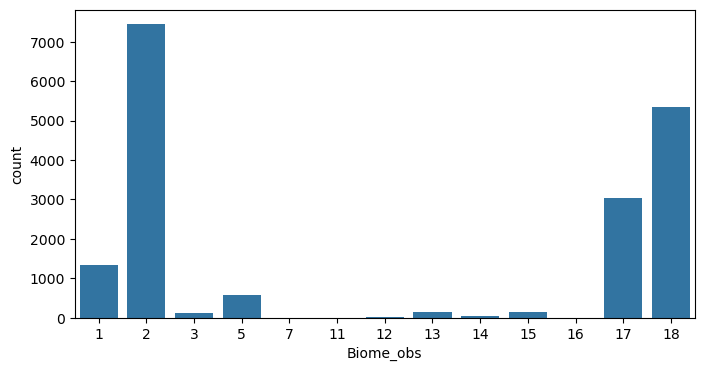

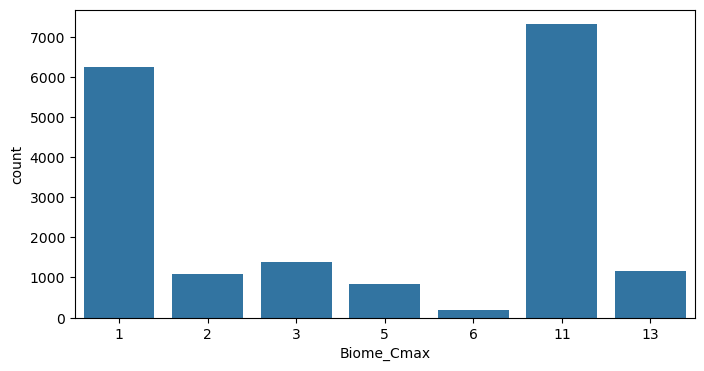

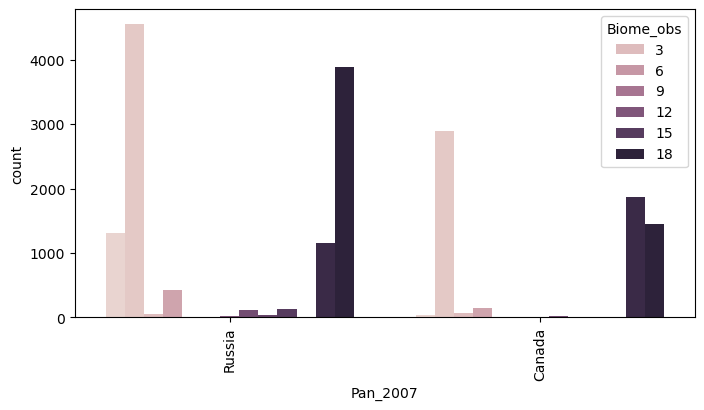

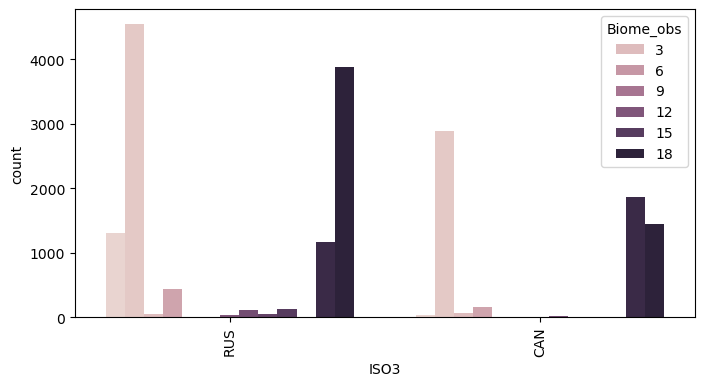

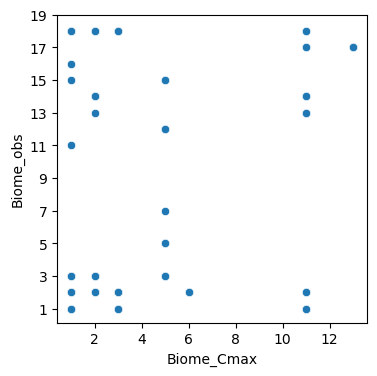

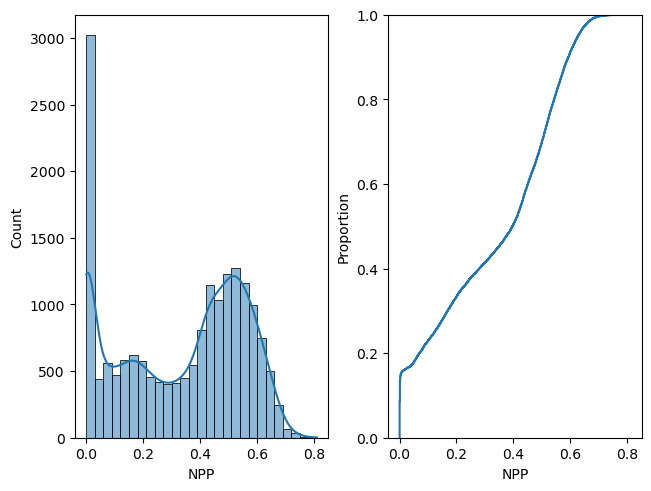

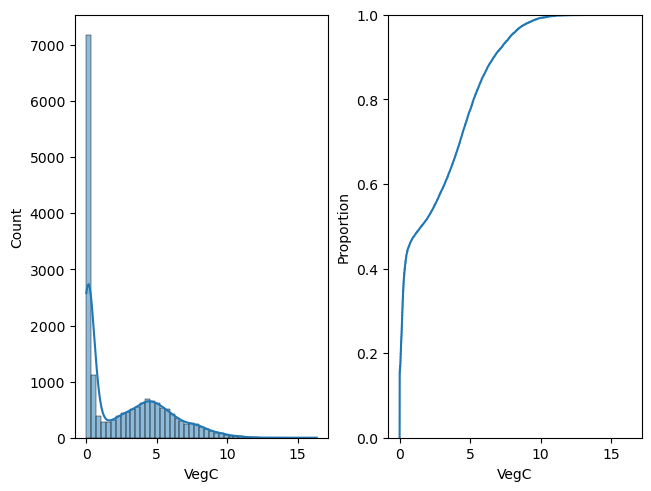

In [246]:
region_train_4 = data_index_2['Pan_2007'] == 'Russia'
region_test_4 = data_index_2['Pan_2007'] == 'Canada'

# plot the data
data1 = data_index_2.loc[region_train_4] 
data2 = data_index_2.loc[region_test_4]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section4Canada_Russia')

And now we run the simulation

In [258]:
model_run(region_train_4, region_test_4, future_plots = False, experiment_name='s4_basic')

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9793 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9603
Balanced accuracy of RandomForestClassifier on train data: 0.6615


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          24    94   0    0   0   0   0   0     0     2
2           4  2790  54   37   1   5   1   1     0    24
3           0     2   2    2   0   0   0   0     0     0
5           0     1  10  115   0   0   0   0     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0   9   0   0     0     0
14          0     0   0    0   0   2   8   0     0     0
15          0     1   0    0   0   0   0   4     0     0
17          0     0   0    0   0   0   0   0  1869     5
18          6     3   0    0   0   2   0   0     1  1418

precision    recall  f1-score      support
1              0.200000  0.705882  0.311688    34.000000
2              0.956462  0.965064  0.960744  2891.000000
3              0.333333  0.030303  0.055556    66.000000
5              0.912698  0.746753  0.821429   154.000000
12                  NaN  0.000000       NaN     1.000000
13             1.000000  0.500000  0.666667    18.000000
14             0.800000  0.888889  0.842105     9.000000
15             0.800000  0.800000  0.800000     5.000000
17             0.997332  0.999465  0.998397  1870.000000
18             0.991608  0.978606  0.985064  1449.000000
accuracy       0.960289  0.960289  0.960289     0.960289
macro avg      0.776826  0.661496  0.715739  6497.000000
weighted avg   0.964523  0.960289  0.960008  6497.000000

---
 The feature importance

importance
VegC                0.150247
LitterC             0.077989
NPP                 0.067365
tmp_WinterMean      0.042188
tmp_WinterMedian    0.039423
...                      ...
clay                0.000559
sand                0.000473
orgC                0.000342
CN                  0.000333
GFED-region         0.000052

[73 rows x 1 columns]

---

This is relatively bad performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal. Let's see how good it is.

In [259]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, experiment_name='s4_tuning')

length of training data: 11696
length of testing data: 6497
Max Depth:  5
Max Trees:  50
Min Leafs:  1
Max CV:  0.6666666666666666
Accuracy of RandomForestClassifier on train data: 0.9655
Balanced accuracy of RandomForestClassifier on train data: 0.6639
Accuracy RandomForestClassifier on cross validation: 0.9590 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9604
Balanced accuracy of RandomForestClassifier on train data: 0.4554


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          17    54   0    0   0   0   0   0     0     2
2          10  2796  35   14   1  12   3   1     0    24
3           0     0   0    0   0   0   0   0     0     0
5           0    36  31  140   0   0   0   3     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0   0   0   0     0     0
14          0     0   0    0   0   0   0   0     0     0
15          0     2   0    0   0   0   0   1     0     0
17          0     0   0    0   0   0   0   0  1867     4
18          7     3   0    0   0   6   6   0     3  1419

precision    recall  f1-score      support
1              0.232877  0.500000  0.317757    34.000000
2              0.965470  0.967139  0.966304  2891.000000
3                   NaN  0.000000       NaN    66.000000
5              0.666667  0.909091  0.769231   154.000000
12                  NaN  0.000000       NaN     1.000000
13                  NaN  0.000000       NaN    18.000000
14                  NaN  0.000000       NaN     9.000000
15             0.333333  0.200000  0.250000     5.000000
17             0.997862  0.998396  0.998129  1870.000000
18             0.982687  0.979296  0.980989  1449.000000
accuracy       0.960443  0.960443  0.960443     0.960443
macro avg      0.696483  0.455392  0.713735  6497.000000
weighted avg   0.967256  0.960443  0.970178  6497.000000

---
 The feature importance

importance
VegC              0.151939
LitterC           0.081624
NPP               0.060112
SoilR             0.044499
tmp_WinterMean    0.043113
...                    ...
CN                0.000035
cellfraction      0.000020
clay              0.000000
orgC              0.000000
GFED-region       0.000000

[73 rows x 1 columns]

---

It's not too good in this case. But when we were previously comparing Africa with China fiddling with the parameters actually did improve things. In the following we will thus disable the hyperparameter tuning. Let's see if things improve if we drop the features with medians.

In [248]:
model_run(region_train_4, region_test_4, drop_columns=features_median)

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9797 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9567
Balanced accuracy of RandomForestClassifier on train data: 0.6067


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          20   109   0    0   0   0   0   0     0     0
2           8  2777  60   40   1   6   0   1     0    24
3           0     1   1    4   0   0   0   0     0     0
5           0     0   5  110   0   0   0   3     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0  11   0   0     0     0
14          0     0   0    0   0   0   9   0     0     2
15          0     0   0    0   0   0   0   1     0     0
17          0     0   0    0   0   0   0   0  1869     5
18          6     4   0    0   0   1   0   0     1  1418

precision    recall  f1-score      support
1              0.155039  0.588235  0.245399    34.000000
2              0.952005  0.960567  0.956267  2891.000000
3              0.166667  0.015152  0.027778    66.000000
5              0.932203  0.714286  0.808824   154.000000
12                  NaN  0.000000       NaN     1.000000
13             1.000000  0.611111  0.758621    18.000000
14             0.818182  1.000000  0.900000     9.000000
15             1.000000  0.200000  0.333333     5.000000
17             0.997332  0.999465  0.998397  1870.000000
18             0.991608  0.978606  0.985064  1449.000000
accuracy       0.956749  0.956749  0.956749     0.956749
macro avg      0.779226  0.606742  0.668187  6497.000000
weighted avg   0.961252  0.956749  0.957064  6497.000000

---
 The feature importance

importance
VegC                0.141514
LitterC             0.072748
NPP                 0.072228
tmin_SpringMean     0.069247
SoilR               0.062421
tmin_WinterMean     0.062311
tmp_SpringMean      0.041714
tmp_WinterMean      0.040666
tmp_FallMean        0.037305
SoilC               0.034651
tmax_WinterMean     0.030903
tmax_SpringStd      0.025285
tmin_FallMean       0.024030
tmax_SpringMean     0.021058
tmin_SummerStd      0.020395
tmax_FallMean       0.017803
tmin_SummerMean     0.016731
tmin_WinterStd      0.015510
tmax_SummerMean     0.014670
tmp_SummerMean      0.014268
tmp_WinterStd       0.012268
tmax_SummerStd      0.011408
tmp_SpringStd       0.010483
tswrf_FallMean      0.009718
tmax_WinterStd      0.009507
tmp_FallStd         0.009017
tswrf_WinterMean    0.008709
tswrf_SpringMean    0.007458
tmin_FallStd        0.006846
tmin_SpringStd      0.006518
tmp_SummerStd       0.006317
tswrf_WinterStd     0.006096
tswrf_SummerMean    0.005811
tmax_FallStd        0.005671
Pre_WinterMean      0.005544
Pre_SpringMean      0.004911
Pre_SummerMean      0.004775
Pre_SpringStd       0.004467
Pre_FallMean        0.004121
tswrf_SpringStd     0.003739
Pre_WinterStd       0.003428
tswrf_FallStd       0.003197
tswrf_SummerStd     0.003015
Pre_SummerStd       0.002968
Pre_FallStd         0.002757
orgC                0.001135
clay                0.000996
cellfraction        0.000887
pH                  0.000849
sand                0.000743
silt                0.000723
CN                  0.000360
GFED-region         0.000104

---

That did not make much of a difference. Let's see what happens if we remove the entire weather data.

In [249]:
model_run(region_train_4, region_test_4, drop_columns=features_weather, experiment_name = "s4_weather")

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9597 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9334
Balanced accuracy of RandomForestClassifier on train data: 0.3876


---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          11    68   0    0   0   0   0   0     0     8
2          17  2810  66  149   1   0   0   5     0    22
3           0     0   0    0   0   0   0   0     0     0
5           0     9   0    5   0   0   0   0     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0  11   0   0     0    55
14          0     0   0    0   0   0   0   0     0     0
15          0     0   0    0   0   0   0   0     0     0
17          0     0   0    0   0   0   0   0  1870     7
18          6     4   0    0   0   7   9   0     0  1357

precision    recall  f1-score      support
1              0.126437  0.323529  0.181818    34.000000
2              0.915309  0.971982  0.942795  2891.000000
3                   NaN  0.000000       NaN    66.000000
5              0.357143  0.032468  0.059524   154.000000
12                  NaN  0.000000       NaN     1.000000
13             0.166667  0.611111  0.261905    18.000000
14                  NaN  0.000000       NaN     9.000000
15                  NaN  0.000000       NaN     5.000000
17             0.996271  1.000000  0.998132  1870.000000
18             0.981200  0.936508  0.958333  1449.000000
accuracy       0.933354  0.933354  0.933354     0.933354
macro avg      0.590504  0.387560  0.567084  6497.000000
weighted avg   0.934109  0.933354  0.935289  6497.000000

---
 The feature importance

importance
VegC            0.277137
SoilR           0.156503
LitterC         0.148339
NPP             0.144977
SoilC           0.113657
orgC            0.022558
pH              0.022547
sand            0.021722
clay            0.021235
cellfraction    0.020693
CN              0.017368
silt            0.017200
GFED-region     0.016065

---

In [ ]:
model_run(region_train_4, region_test_4, drop_columns=features_weather, experiment_name='s4_dropWeather')

In [ ]:
model_run(region_train_4, region_test_4, use_columns=features_weather, experiment_name='s4_useWeather')

In [ ]:
model_run(region_train_4, region_test_4, drop_columns=features_median, experiment_name='s4_dropMedian')

Apparently the weather is important, but not very. Let's see what effect the different seasons have

In [250]:
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]

for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
               drop_columns=features_seasons[i], experiment_name=f's3_drop_{season}')

We see that dropping fall decreased the performance the most whilst dropping the summer actually increased performance slightly. Let's see what happens if we use only weather data.

In [251]:
print(features_weather)
model_run(region_train_4, region_test_4, use_columns=features_weather)

['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean', 'Pre_SummerMedian', 'P

---
 The confusion table

Truth      1     2   3    5   12  13  14  15    17    18
Predicted                                               
1          17   120   0    0   0   0   0   0     0    12
2           0  2725  63   48   1  17   7   1     2   254
3           0     0   0    2   0   0   0   0     0     0
5           0     4   3  103   0   0   0   0     0     0
12          0     0   0    0   0   0   0   0     0     0
13          0     0   0    0   0   0   0   0     0     0
14          0     1   0    0   0   1   2   0     4     0
15          0     1   0    1   0   0   0   4     0     0
17          0     0   0    0   0   0   0   0  1598    64
18         17    40   0    0   0   0   0   0   266  1119

precision    recall  f1-score      support
1              0.114094  0.500000  0.185792    34.000000
2              0.873958  0.942580  0.906973  2891.000000
3              0.000000  0.000000       NaN    66.000000
5              0.936364  0.668831  0.780303   154.000000
12                  NaN  0.000000       NaN     1.000000
13                  NaN  0.000000       NaN    18.000000
14             0.250000  0.222222  0.235294     9.000000
15             0.666667  0.800000  0.727273     5.000000
17             0.961492  0.854545  0.904870  1870.000000
18             0.776006  0.772257  0.774127  1449.000000
accuracy       0.857011  0.857011  0.857011     0.857011
macro avg      0.572322  0.476044  0.644947  6497.000000
weighted avg   0.864881  0.857011  0.868389  6497.000000

---
 The feature importance

importance
tmp_FallMean          0.064355
tmin_SpringMean       0.060968
tmin_WinterMean       0.052461
tmin_WinterMedian     0.039353
tmp_FallMedian        0.039063
tmp_SpringMedian      0.037696
tmp_WinterMedian      0.037062
tmp_WinterMean        0.036015
tmin_SpringMedian     0.033639
tmp_SpringMean        0.031454
tmax_SpringMedian     0.028300
tmax_SpringMean       0.025317
tmax_SummerMedian     0.024402
tmp_SummerMedian      0.022771
tmax_FallMean         0.022507
tmax_WinterMedian     0.021401
tmin_FallMean         0.021007
tmax_WinterMean       0.020609
tmax_FallMedian       0.020050
tmp_SummerMean        0.020003
tmin_SummerMedian     0.019404
tmax_SummerMean       0.019308
tmin_FallMedian       0.017692
tmax_SpringStd        0.016543
tmin_SummerStd        0.013529
tmp_SpringStd         0.012500
tswrf_SpringMedian    0.012299
tswrf_FallMean        0.011204
tswrf_SummerStd       0.010828
tswrf_WinterMean      0.010449
tmp_FallStd           0.009747
tmin_WinterStd        0.009060
tmin_SummerMean       0.008491
tmp_WinterStd         0.008272
tswrf_WinterStd       0.008142
Pre_WinterMean        0.008028
tmin_SpringStd        0.007934
tswrf_FallStd         0.007842
Pre_FallMean          0.007734
tmp_SummerStd         0.007712
tswrf_SpringMean      0.006843
Pre_SummerMean        0.006822
Pre_SummerMedian      0.006730
Pre_FallMedian        0.006644
tmax_WinterStd        0.006630
Pre_SpringStd         0.006462
Pre_FallStd           0.006169
tswrf_WinterMedian    0.005997
tmax_FallStd          0.005931
tswrf_SummerMean      0.005883
tmin_FallStd          0.005740
Pre_SpringMedian      0.005609
Pre_SpringMean        0.005452
Pre_SummerStd         0.005337
tmax_SummerStd        0.005132
tswrf_SpringStd       0.005098
tswrf_FallMedian      0.004715
Pre_WinterMedian      0.004632
Pre_WinterStd         0.004559
tswrf_SummerMedian    0.004462

---

Turn's out that using only weather to classify biomes does not really go well. Let's see if the model works better at classifying 'Biome_Cmax'.

In [252]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax')

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9551 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9001
Balanced accuracy of RandomForestClassifier on train data: 0.7428


---
 The confusion table

Truth        1    2   3    5     11   13
Predicted                               
1          2411  368   2   29    19    0
2             1    2   0    0     0    0
3           121    1  22    0     3    0
5            15   21   0  172     0    0
11           11    3   7    0  2257   48
13            0    0   0    0     0  986

precision    recall  f1-score      support
1              0.852245  0.942165  0.894952  2559.000000
2              0.666667  0.005063  0.010050   395.000000
3              0.149660  0.709677  0.247191    31.000000
5              0.826923  0.855721  0.841076   201.000000
11             0.970335  0.990347  0.980239  2279.000000
13             1.000000  0.953578  0.976238  1034.000000
accuracy       0.900138  0.900138  0.900138     0.900138
macro avg      0.744305  0.742759  0.658291  6499.000000
weighted avg   0.901750  0.900138  0.879253  6499.000000

---
 The feature importance

importance
VegC                0.127284
LitterC             0.081275
NPP                 0.050724
tmp_SpringMedian    0.040245
tmp_WinterMedian    0.039114
...                      ...
silt                0.001060
pH                  0.000683
orgC                0.000629
CN                  0.000456
GFED-region         0.000076

[73 rows x 1 columns]

---

That is quite decent performance though not as good as with biome_obs.

## Section 4.6

Test the model trained with 'Biome_Cmax' on 'Biome_obs'.

length of training data: 6499
length of testing data: 6451
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9588 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.1482
Balanced accuracy of RandomForestClassifier on train data: 0.2758


y_pred contains classes not in y_true


---
 The confusion table

Truth       1     2   3    5   11  13
Predicted                            
1          520  4431  27   10   0  20
2            0    15   2    0   0   0
3          756     0   0    0   0   0
5            0    49  21  421   0   0
11          28    57   0    0   0  94
13           0     0   0    0   0   0

precision    recall  f1-score      support
1              0.103834  0.398773  0.164766  1304.000000
2              0.882353  0.003295  0.006566  4552.000000
3              0.000000  0.000000       NaN    50.000000
5              0.857434  0.976798  0.913232   431.000000
11             0.000000       NaN       NaN     0.000000
13                  NaN  0.000000       NaN   114.000000
accuracy       0.148194  0.148194  0.148194     0.148194
macro avg      0.368724  0.275773  0.361521  6451.000000
weighted avg   0.713496  0.148194  0.101534  6451.000000

---
 The feature importance

importance
VegC             0.168905
SoilR            0.064386
tmp_FallMean     0.052049
NPP              0.049608
tmax_FallMean    0.044368
...                   ...
silt             0.000690
clay             0.000608
orgC             0.000532
CN               0.000351
GFED-region      0.000013

[73 rows x 1 columns]

Baseline accuracy on test data with features removed: 0.2407


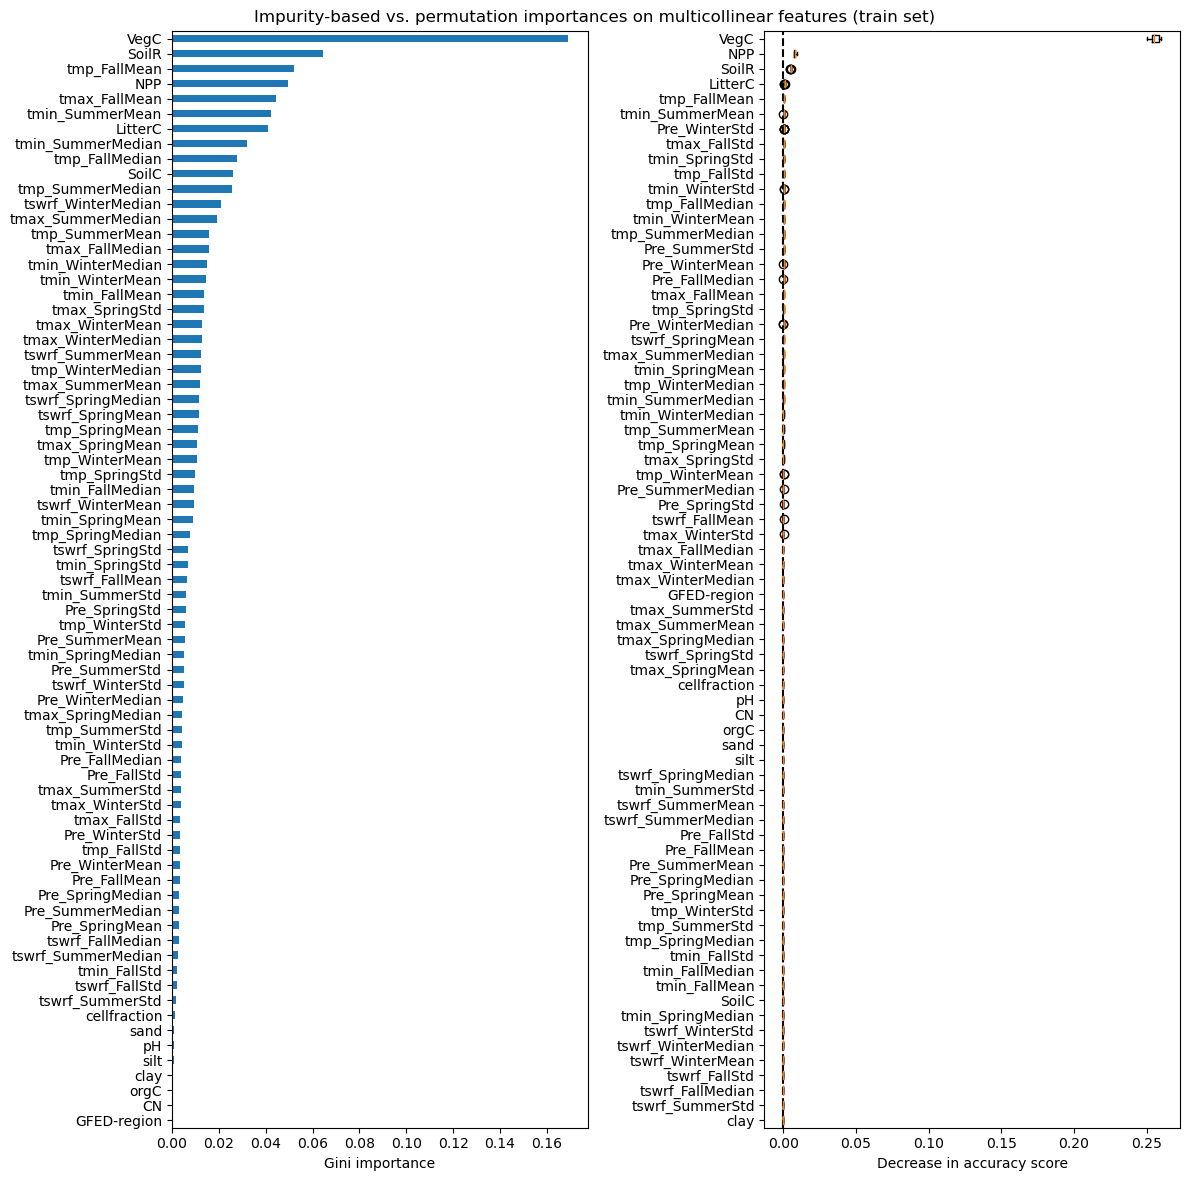

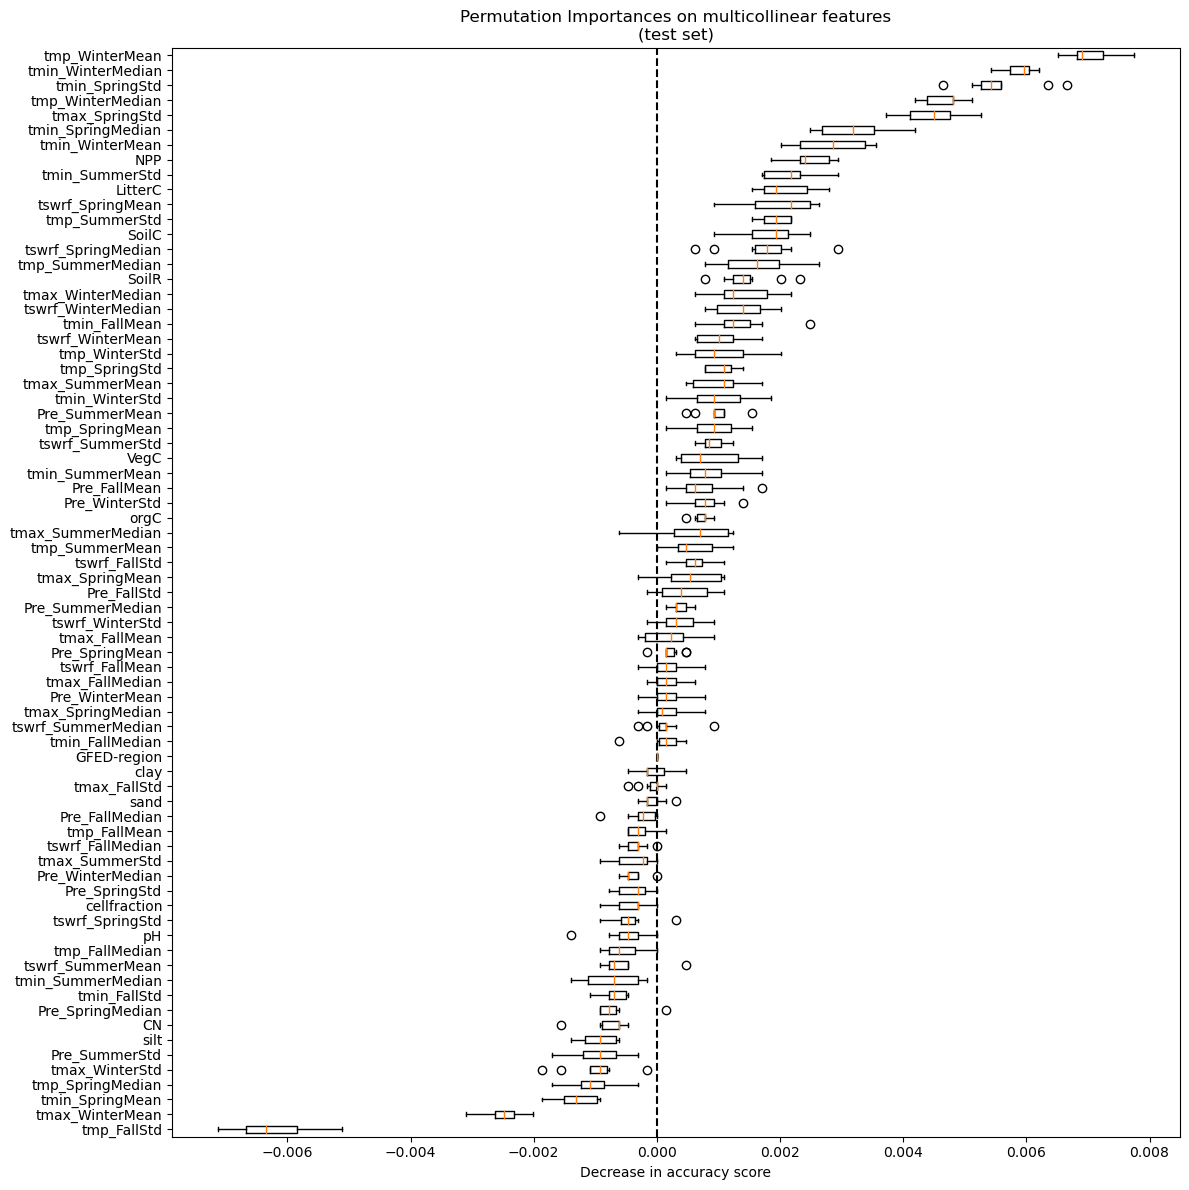

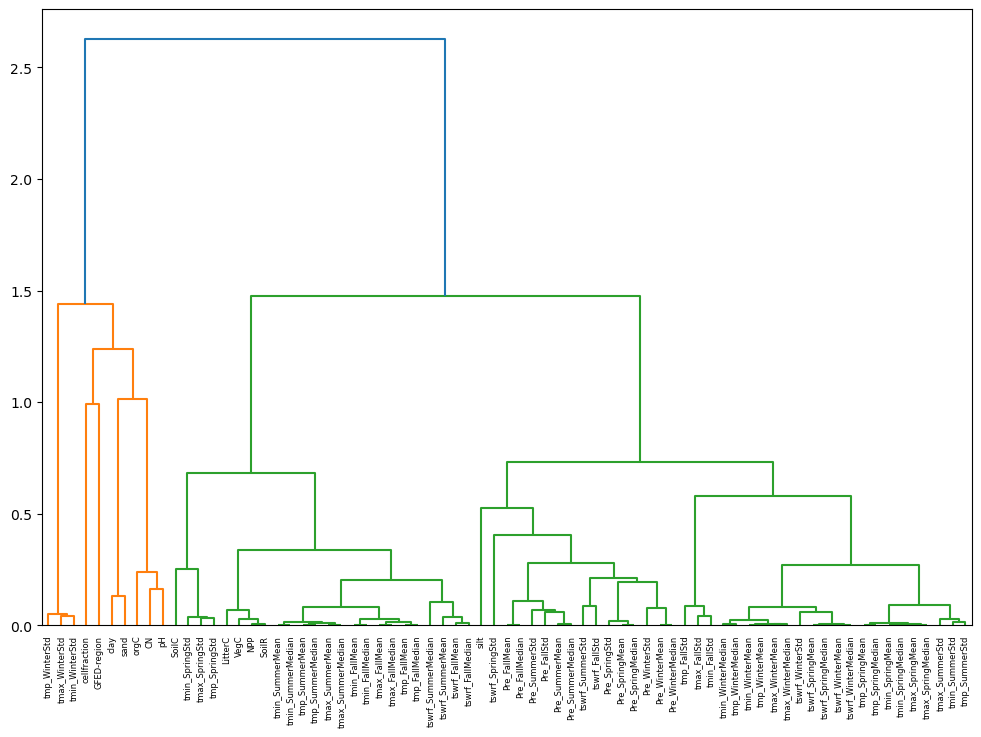

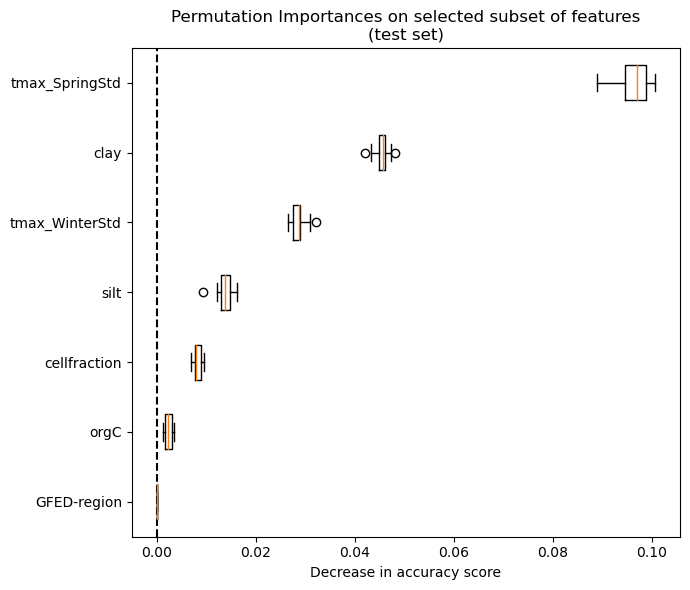

---

In [55]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax', objective_test='Biome_obs')

Who would have thought? The model performs as badly as an antigen test measuring temperature. Now test the model trained on 'Biome_obs' on 'Biome_Cmax' (and expect a similar result).

length of training data: 6499
length of testing data: 11518
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9829 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.0937
Balanced accuracy of RandomForestClassifier on train data: 0.2712


y_pred contains classes not in y_true


---
 The confusion table

Truth        1    2    3    5     11   13  14  15  17  18
Predicted                                                
1             0    0  849    0    12    0   0   0   0   0
2          3641  662  442  197    24    0   0   0   0   0
3             3    0    0    3     0    0   0   0   0   0
5             3    3    0  417     0    0   0   0   0   0
11            0    0    0    0     0    0   0   0   0   0
13            0    0    0    0    11    0   0   0   0   0
14            0    0    0    2     0    0   0   0   0   0
15            0    0    0   12     0    0   0   0   0   0
17            0    0    0    0  1032  119   0   0   0   0
18           49   20   62    0  3955    0   0   0   0   0

precision    recall  f1-score       support
1              0.000000  0.000000       NaN   3696.000000
2              0.133306  0.966423  0.234295    685.000000
3              0.000000  0.000000       NaN   1353.000000
5              0.985816  0.660856  0.791271    631.000000
11                  NaN  0.000000       NaN   5034.000000
13             0.000000  0.000000       NaN    119.000000
14             0.000000       NaN       NaN      0.000000
15             0.000000       NaN       NaN      0.000000
17             0.000000       NaN       NaN      0.000000
18             0.000000       NaN       NaN      0.000000
accuracy       0.093679  0.093679  0.093679      0.093679
macro avg      0.124347  0.271213  0.512783  11518.000000
weighted avg   0.110019  0.093679  0.501356  11518.000000

---
 The feature importance

importance
VegC            0.158840
NPP             0.091555
LitterC         0.078905
SoilR           0.069294
tmp_FallMean    0.056166
...                  ...
orgC            0.000426
CN              0.000376
silt            0.000327
sand            0.000246
GFED-region     0.000002

[73 rows x 1 columns]

Baseline accuracy on test data with features removed: 0.0323


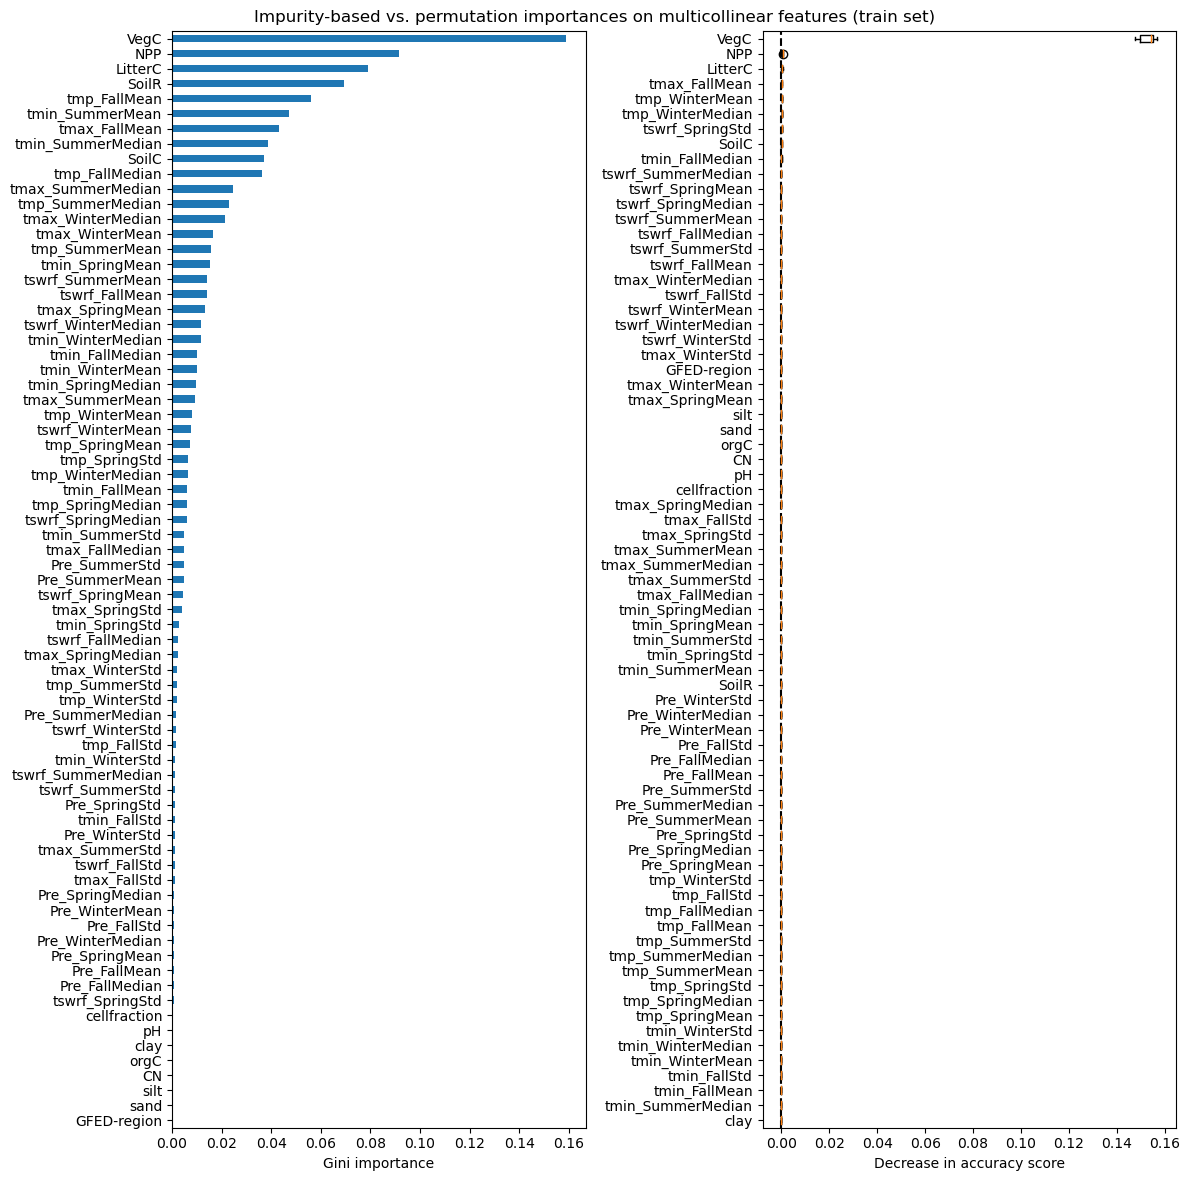

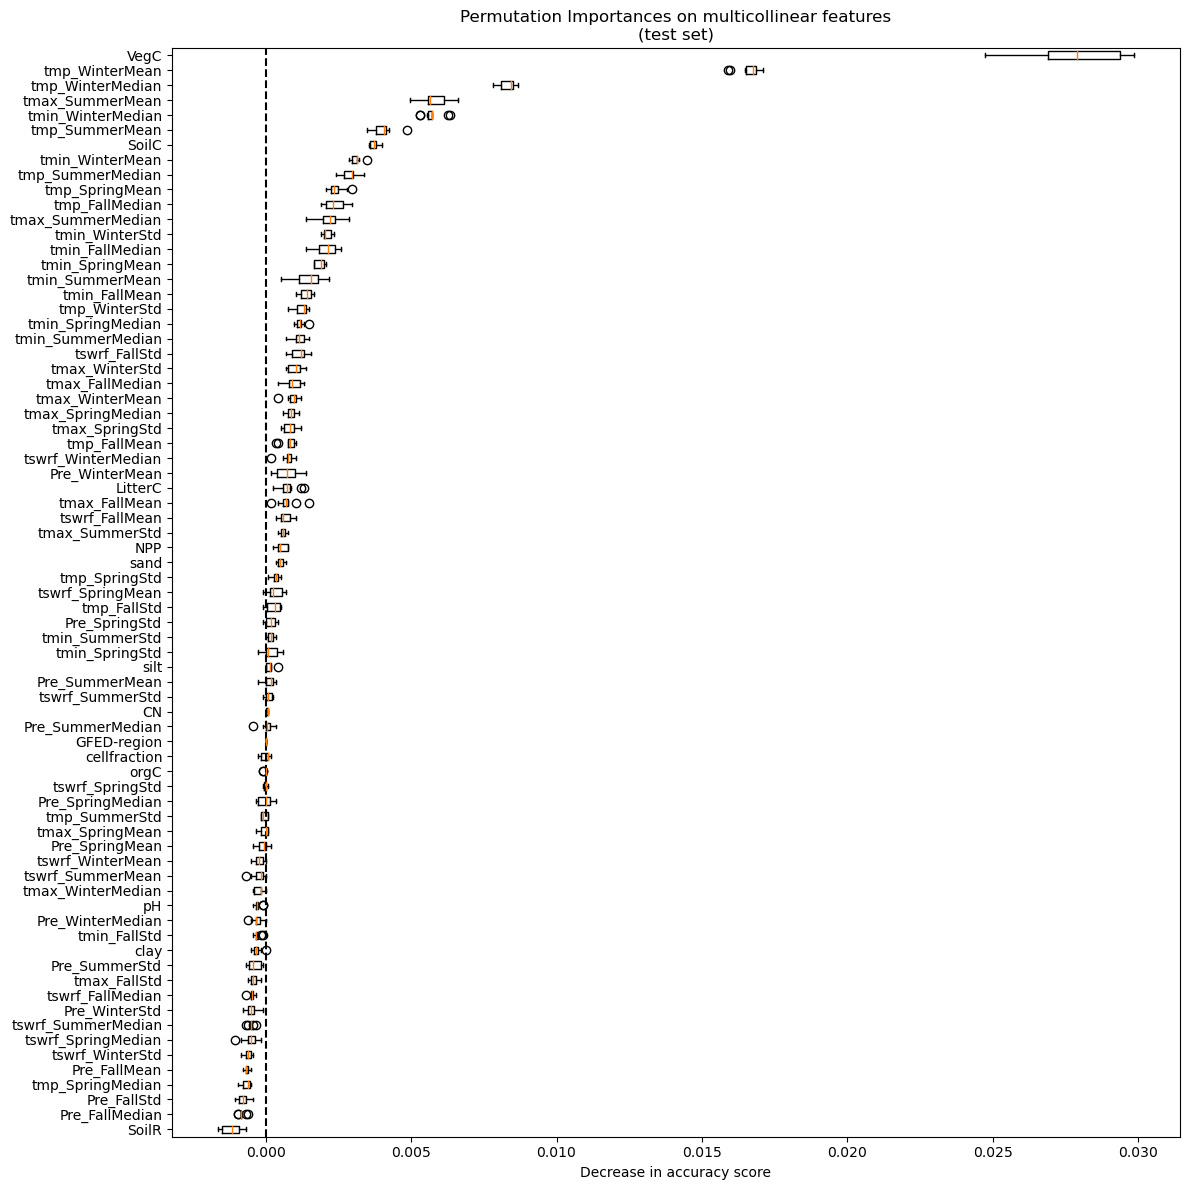

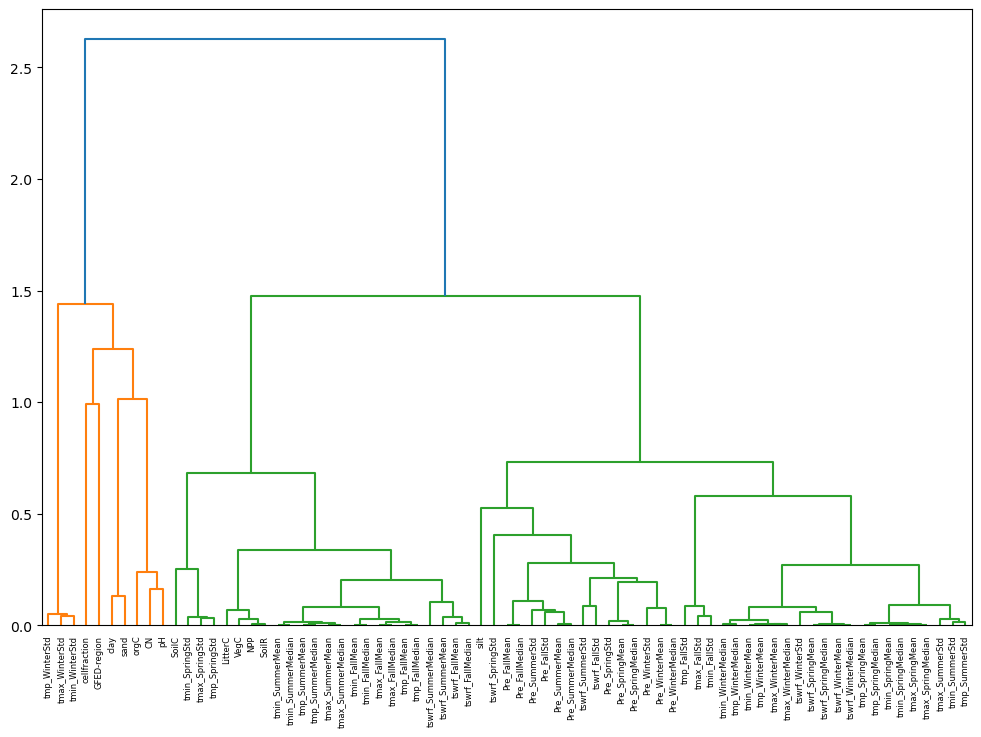

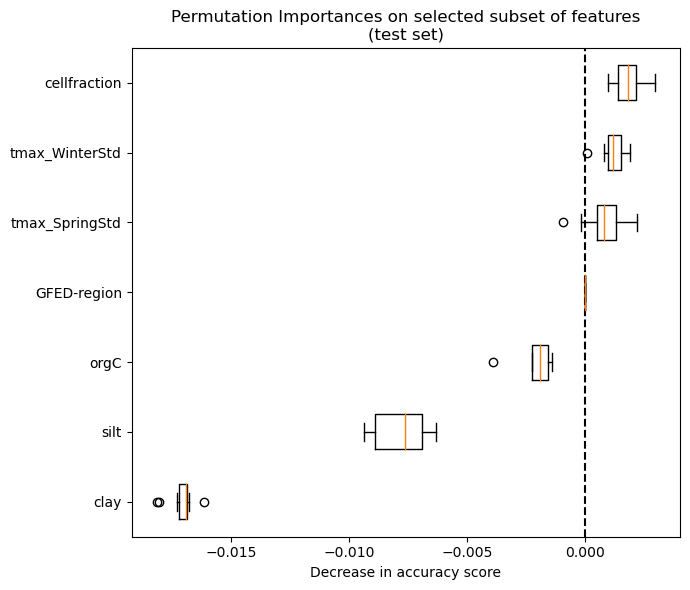

---

In [56]:
model_run(region_train_4, region_test_4, objective='Biome_obs', objective_test='Biome_Cmax')

... and the result is just as bad. What a surprise. Now compare our model with LPJ-Guess output

Comparing LPJ-Guess with our model for the parameter Biome_obs
length of training data: 6499
length of testing data: 9135



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9829 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.1710
Balanced accuracy of RandomForestClassifier on train data: 0.0863


---
 The confusion table

Truth       1    2   3    5   11   12  13   14   15   16   17   18
Predicted                                                         
1           25  172  21   44  17   47  11   54   46   62   83   92
2          112  976  52  364  82  313  27  359  268  425  551  488
3            0    1   1    0   0    0   0    1    0    1    2    1
5           10   80   8   30  10   29   3   28   22   40   40   32
11           0    0   0    0   0    0   0    0    0    0    0    0
12           0    0   0    0   0    0   0    0    0    0    0    0
13           0    2   1    0   0    0   0    1    0    0    1    0
14           0    0   0    0   0    0   0    0    0    0    1    1
15           0    4   0    2   0    0   0    0    0    0    3    1
16           0    0   0    0   0    0   0    0    0    0    0    0
17          23  229   9   66  24   77   8   82   68   89  148   99
18          96  781  51  256  82  231  28  243  209  308  499  382

precision    recall  f1-score      support
1              0.037092  0.093985  0.053191   266.000000
2              0.242967  0.434744  0.311721  2245.000000
3              0.142857  0.006993  0.013333   143.000000
5              0.090361  0.039370  0.054845   762.000000
11                  NaN  0.000000       NaN   215.000000
12                  NaN  0.000000       NaN   697.000000
13             0.000000  0.000000       NaN    77.000000
14             0.000000  0.000000       NaN   768.000000
15             0.000000  0.000000       NaN   613.000000
16                  NaN  0.000000       NaN   925.000000
17             0.160521  0.111446  0.131556  1328.000000
18             0.120657  0.348540  0.179259  1096.000000
accuracy       0.170991  0.170991  0.170991     0.170991
macro avg      0.088273  0.086256  0.123984  9135.000000
weighted avg   0.135657  0.170991  0.193294  9135.000000

---
 The feature importance

importance
VegC            0.158840
NPP             0.091555
LitterC         0.078905
SoilR           0.069294
tmp_FallMean    0.056166
...                  ...
orgC            0.000426
CN              0.000376
silt            0.000327
sand            0.000246
GFED-region     0.000002

[73 rows x 1 columns]

Baseline accuracy on test data with features removed: 0.1959


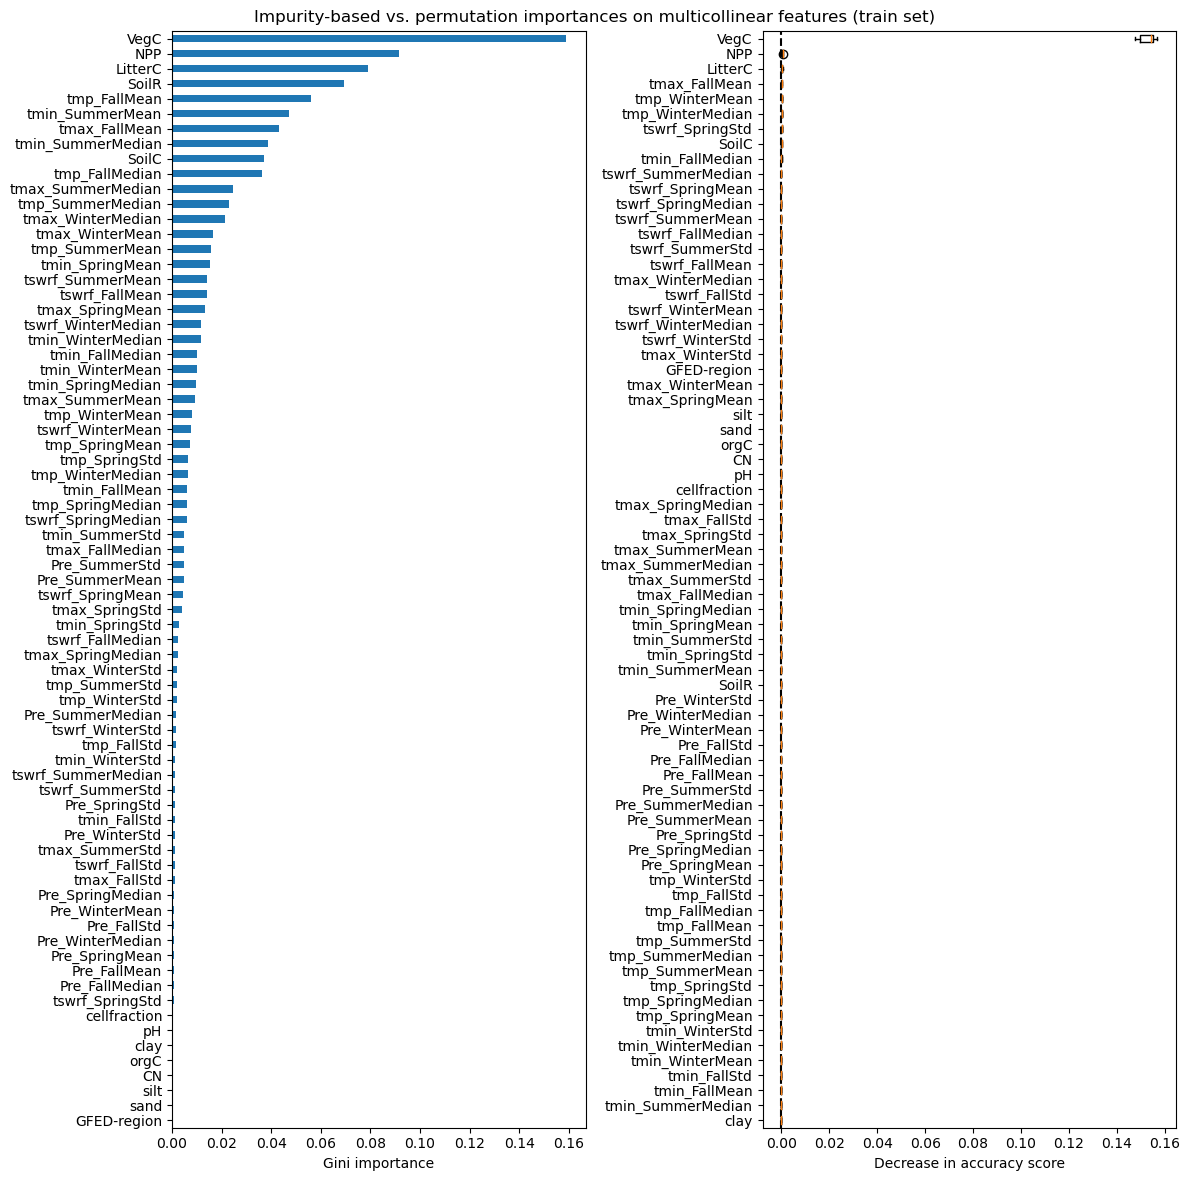

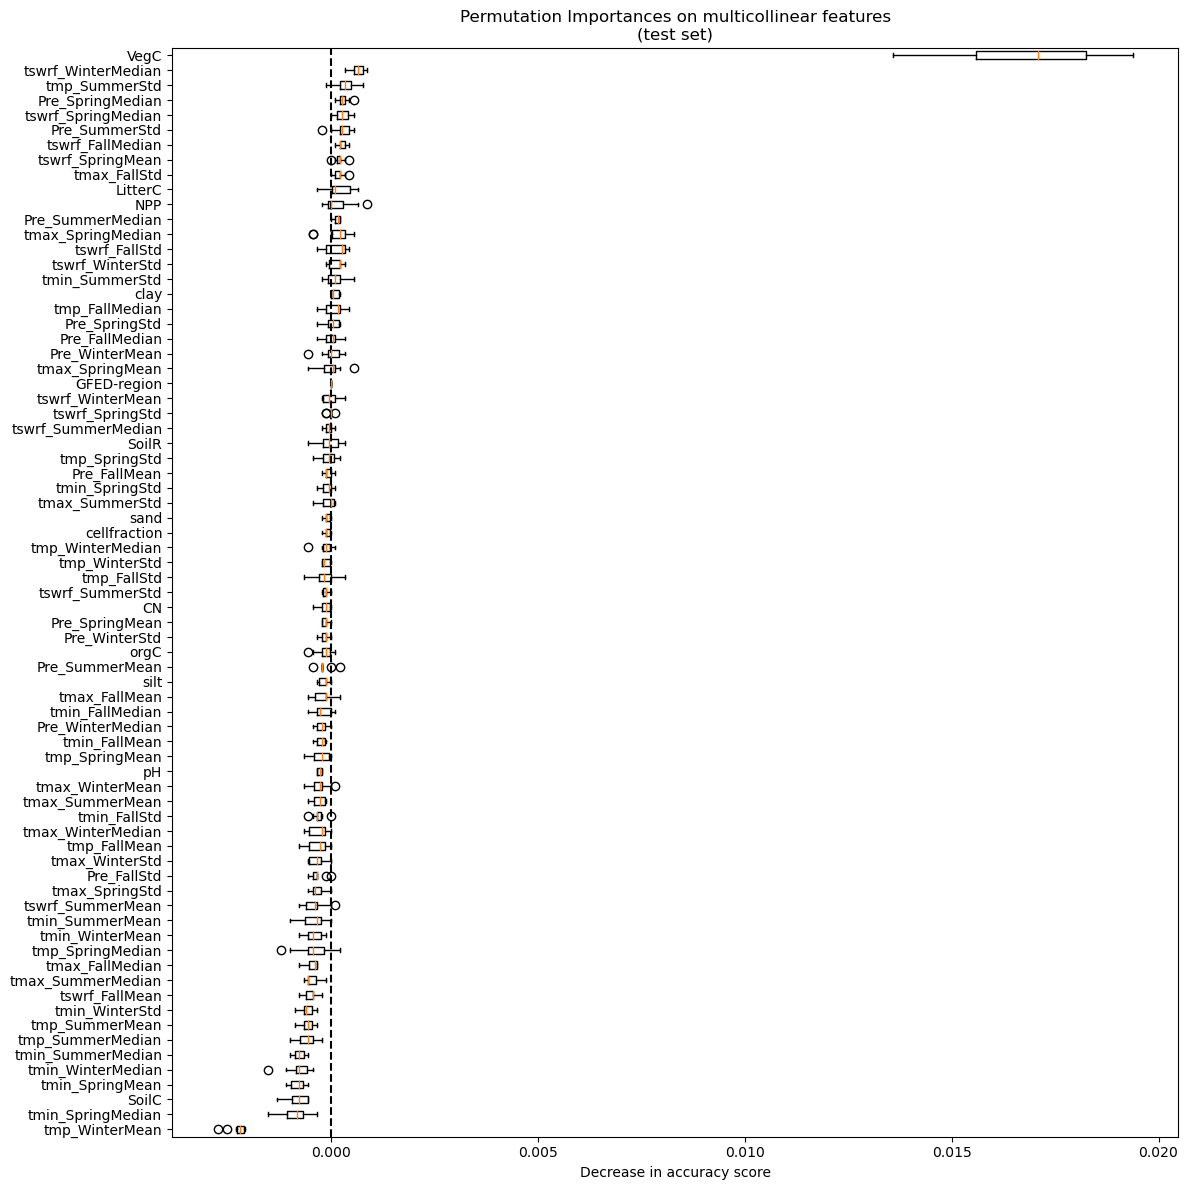

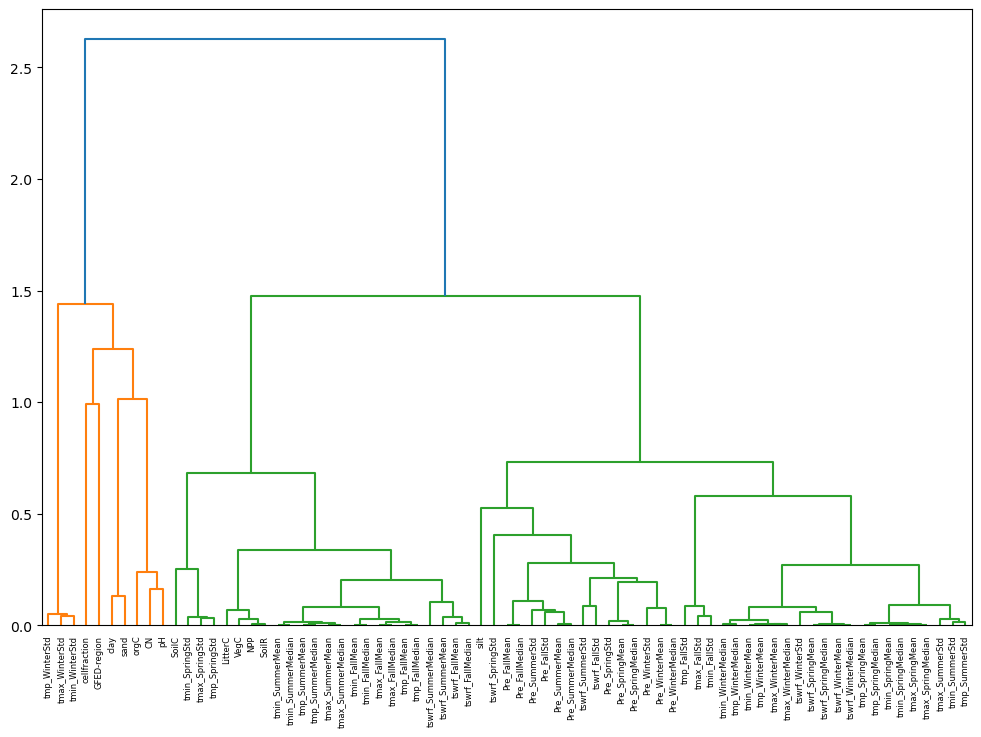

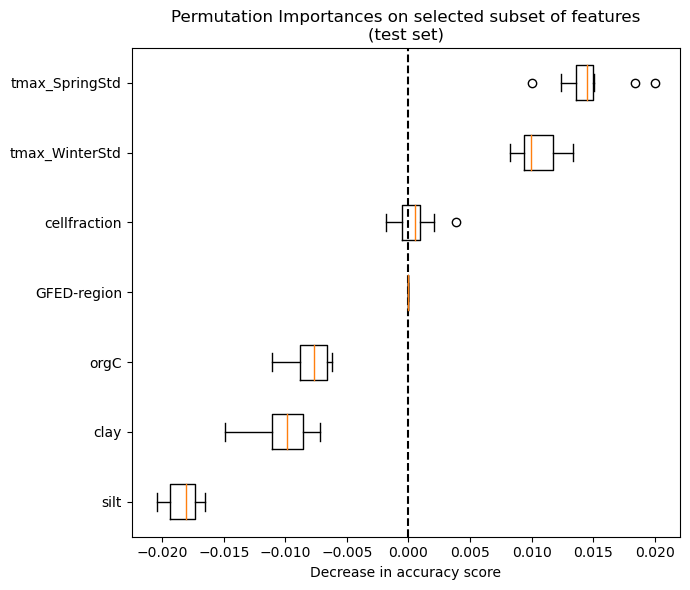

---

Comparing LPJ-Guess with our model for the parameter Biome_Cmax
length of training data: 6499
length of testing data: 6564



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9588 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.2849
Balanced accuracy of RandomForestClassifier on train data: 0.1734


---
 The confusion table

Truth       1    2    3    5    11   13
Predicted                              
1          848  160  117  671  866  162
2            1    0    0    1    4    1
3          145   28   25   97  143   17
5           98   23   18   89  100   14
11         863  165  121  651  900  170
13          24    1    2   14   17    8

precision    recall  f1-score      support
1              0.300283  0.428499  0.353113  1979.000000
2              0.000000  0.000000       NaN   377.000000
3              0.054945  0.088339  0.067751   283.000000
5              0.260234  0.058437  0.095442  1523.000000
11             0.313589  0.443350  0.367347  2030.000000
13             0.121212  0.021505  0.036530   372.000000
accuracy       0.284887  0.284887  0.284887     0.284887
macro avg      0.175044  0.173355  0.184036  6564.000000
weighted avg   0.257133  0.284887  0.262267  6564.000000

---
 The feature importance

importance
VegC             0.168905
SoilR            0.064386
tmp_FallMean     0.052049
NPP              0.049608
tmax_FallMean    0.044368
...                   ...
silt             0.000690
clay             0.000608
orgC             0.000532
CN               0.000351
GFED-region      0.000013

[73 rows x 1 columns]

Baseline accuracy on test data with features removed: 0.2911


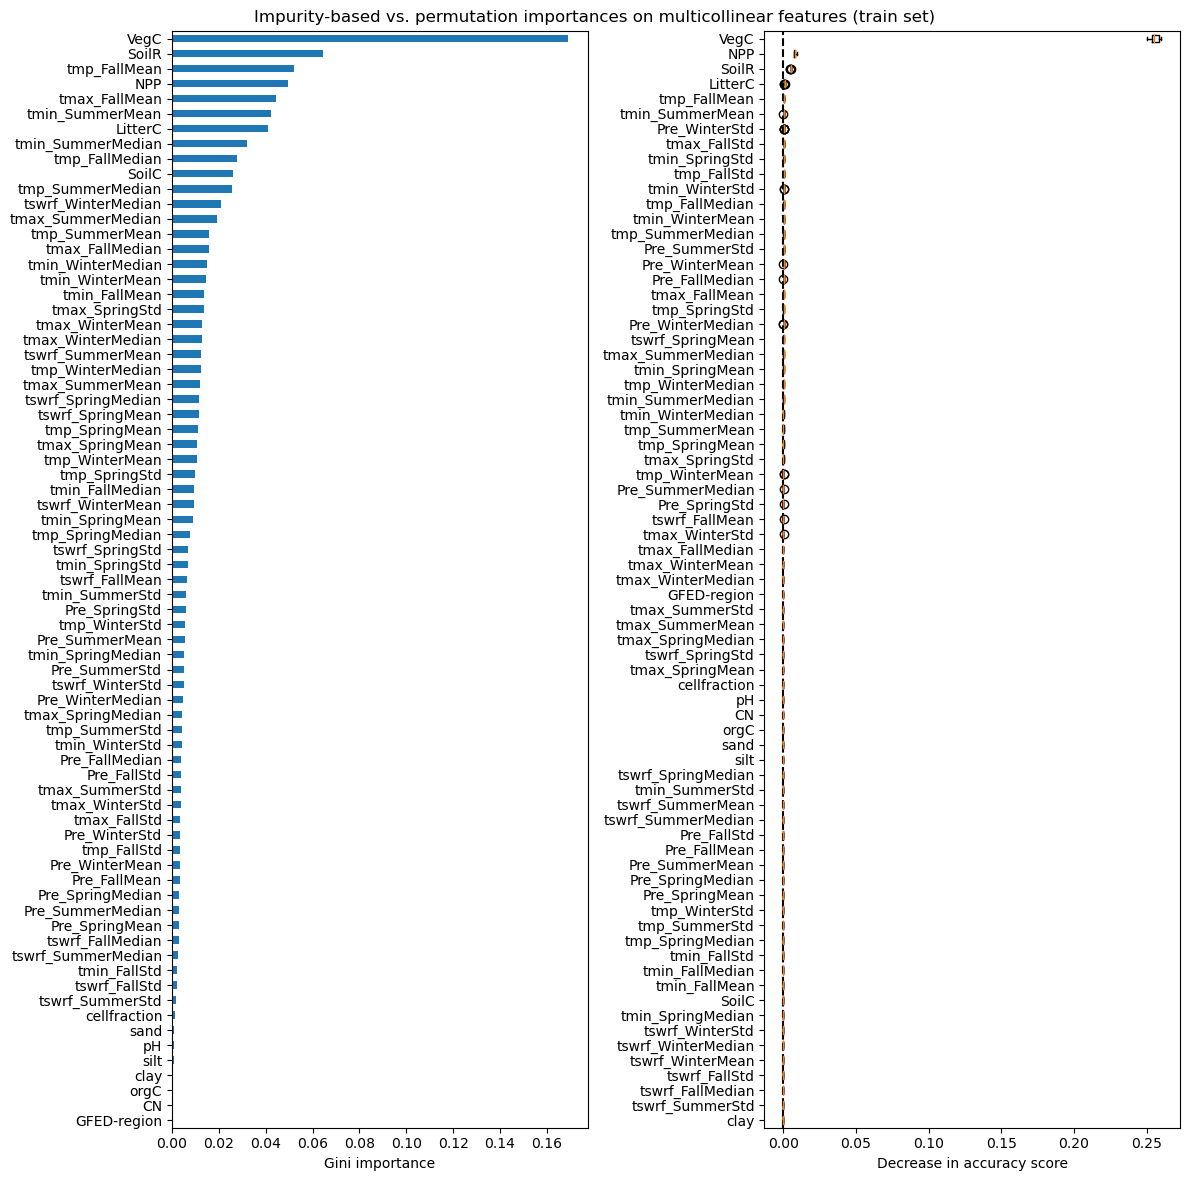

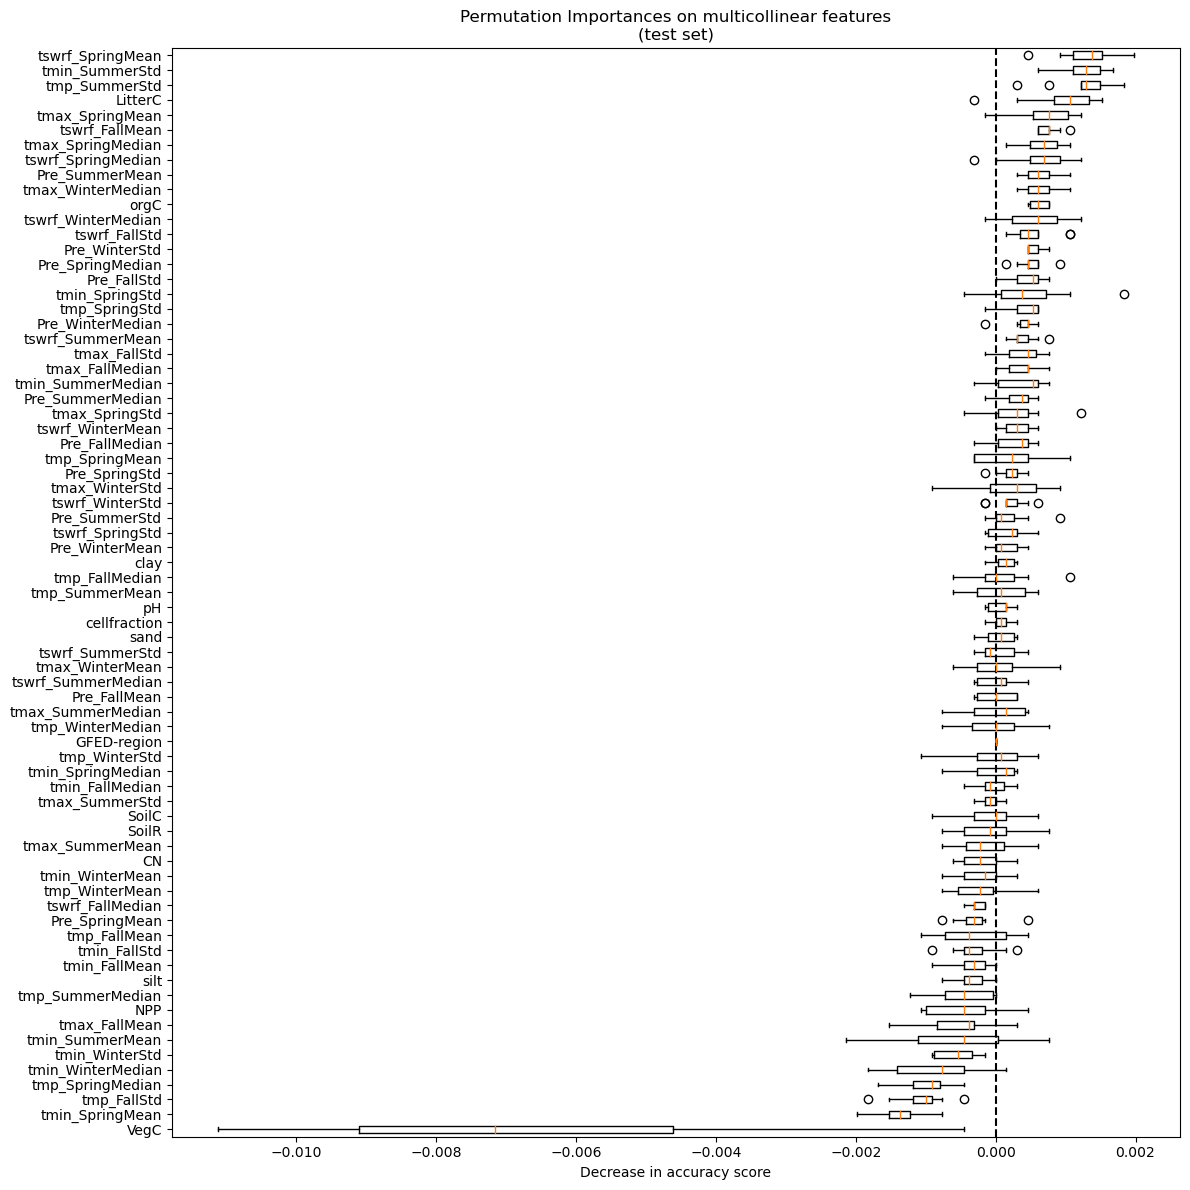

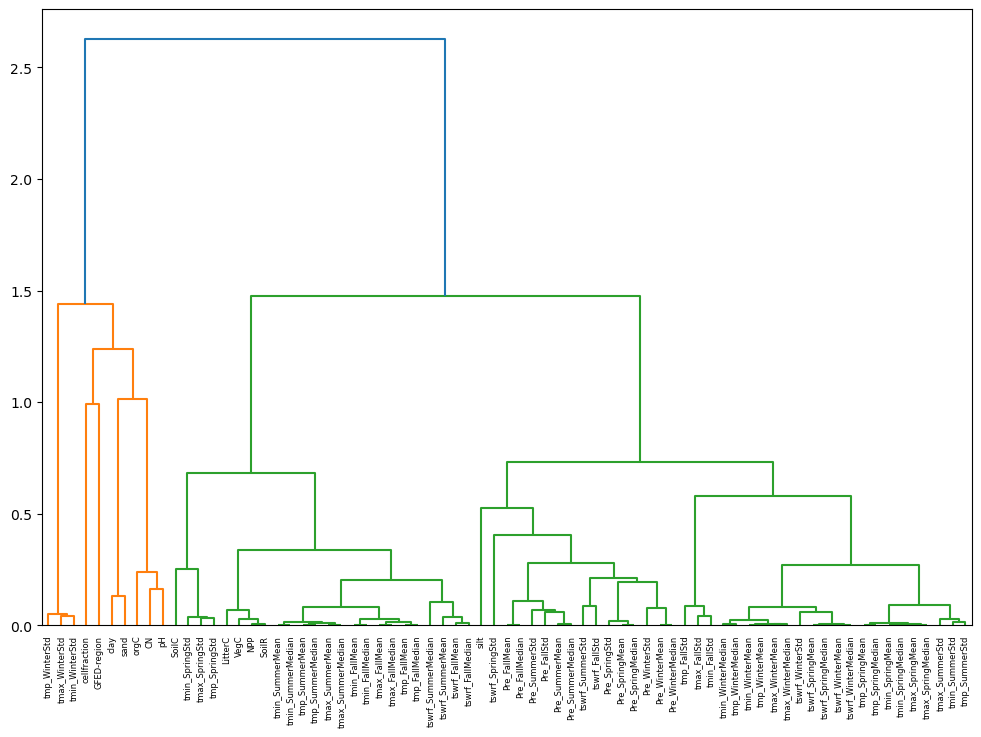

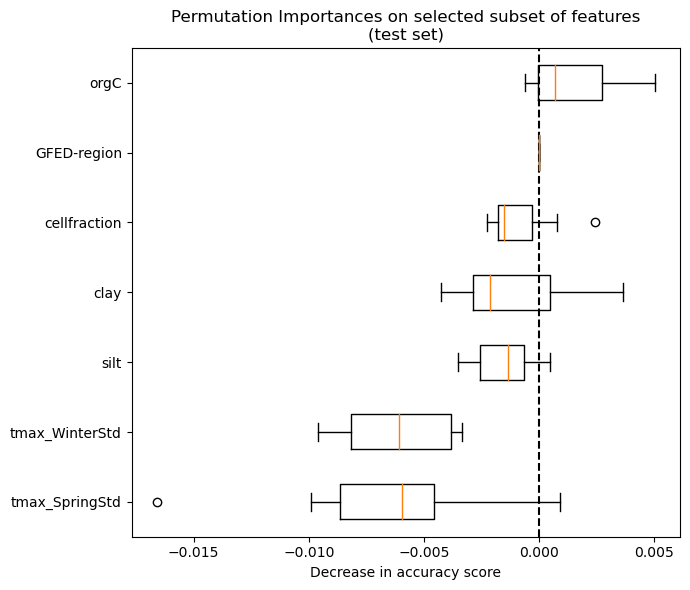

---

In [57]:
for objective in ['Biome_obs','Biome_Cmax']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_4, region_test_4, objective=objective, objective_test=f'LPJ_{objective}')

Who would have thought that our model works badly in this case (duh)?

## Section 5: Regression 

In this part we creatively use the same test and validation set as in part 4

In [58]:
region_train_5 = region_train_4
region_test_5 = region_test_4

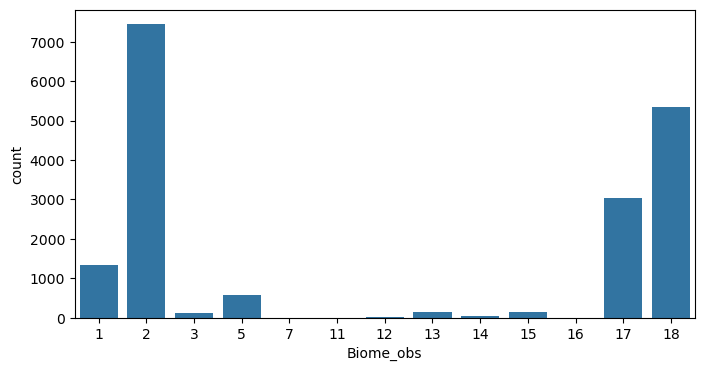

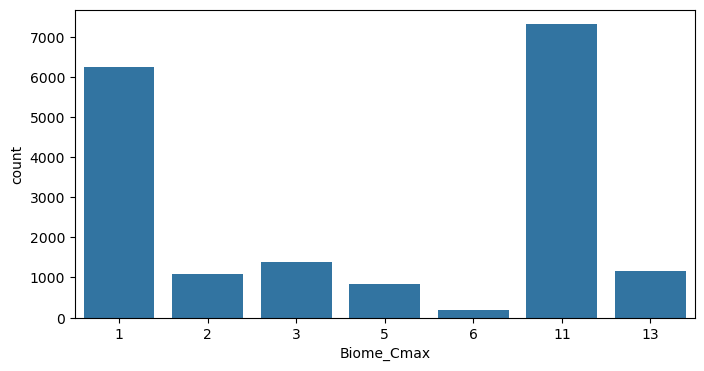

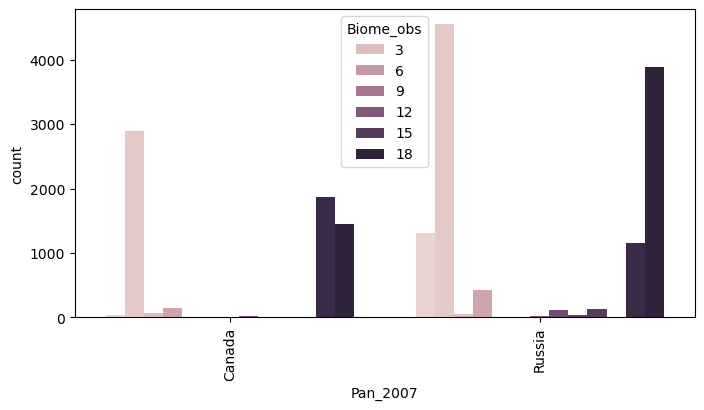

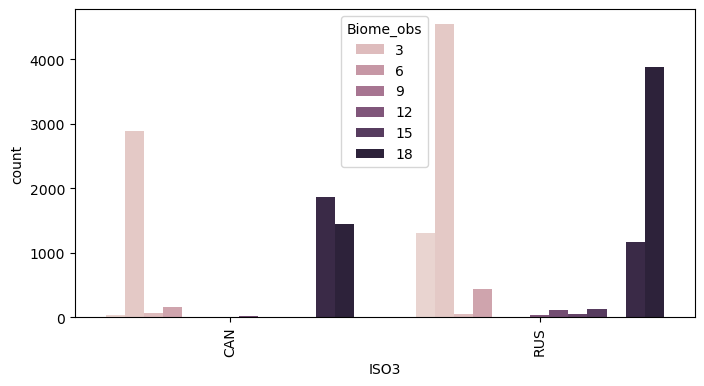

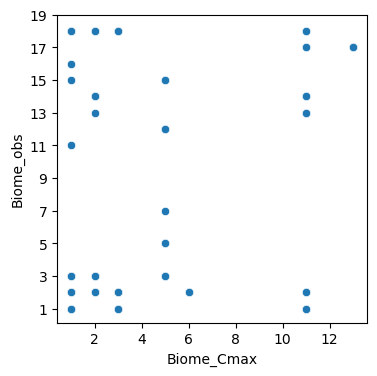

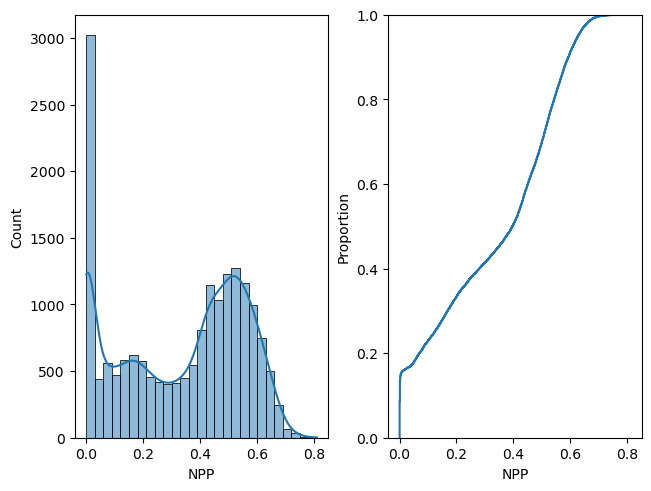

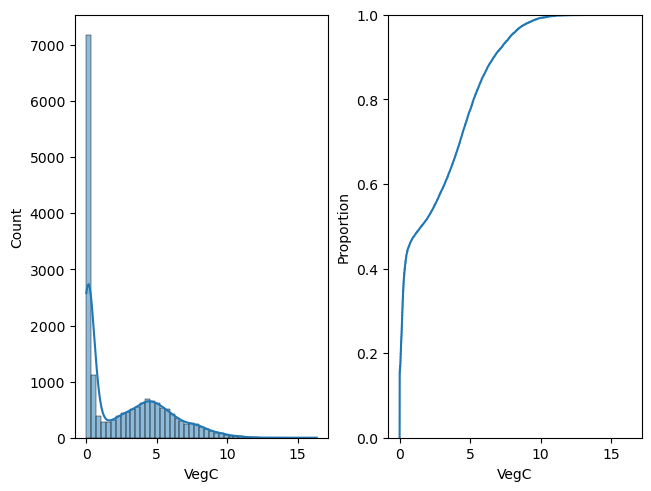

In [59]:
# plot the data
data1 = data_index_2.loc[region_train_5] 
data2 = data_index_2.loc[region_test_5]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section5Canada_Russia')

And we run the model.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9997
Accuracy of RandomForestRegressor on test data: 0.9910
MSE for training data 0.00035219582227257146
MSE (with sktfct) for test  data 0.00035219582227257146
sqrt(MSE) for test data 0.01876688099478897
max error for test data 0.08911000000000002
mean abs error for test data 0.012690091484268124


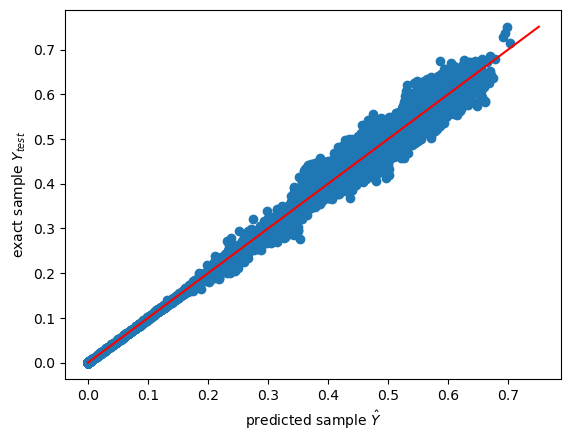

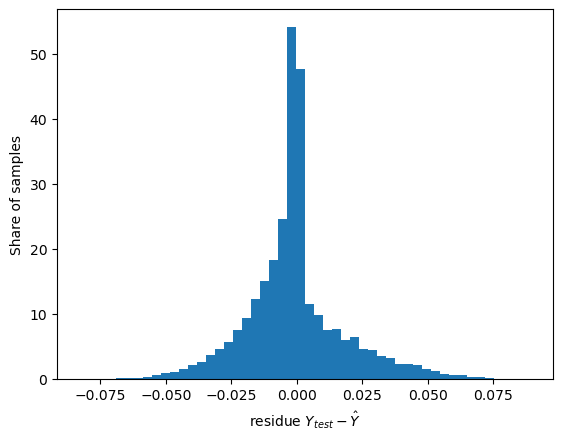

In [60]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True)

A pretty decent outcome. Let's see how it behaves with 'VegC'.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9931
Accuracy of RandomForestRegressor on test data: 0.8444
MSE for training data 1.1148221610141846
MSE (with sktfct) for test  data 1.1148221610141846
sqrt(MSE) for test data 1.0558513915386885
max error for test data 6.62681
mean abs error for test data 0.6244391646716827


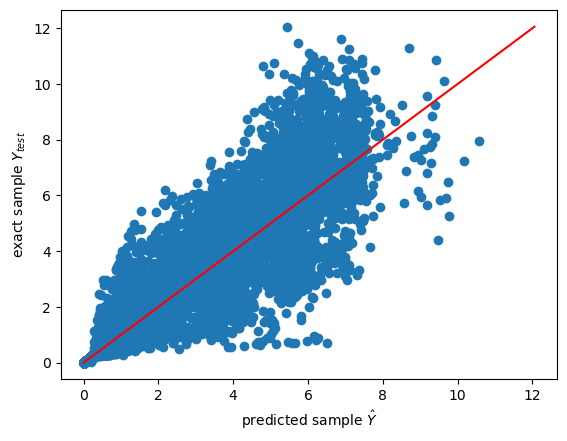

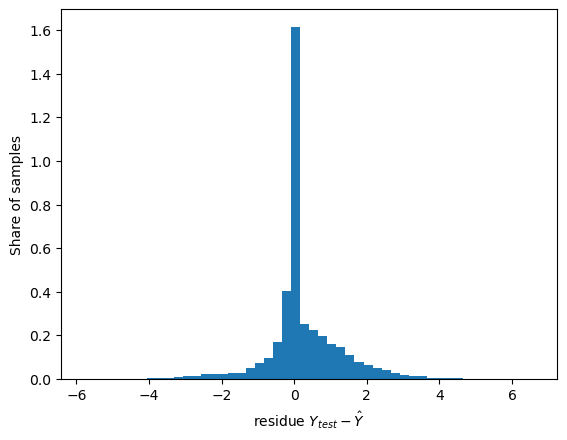

In [61]:
model_run(region_train_5, region_test_5, objective='VegC', continuous_Y=True)

'VegC' seems to perform worse. We analyse the importance of the weather on the prediction.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9996
Accuracy of RandomForestRegressor on test data: 0.9920
MSE for training data 0.00031393392948418517
MSE (with sktfct) for test  data 0.00031393392948418517
sqrt(MSE) for test data 0.017718180761133046
max error for test data 0.08614000000000016
mean abs error for test data 0.011806595431486551


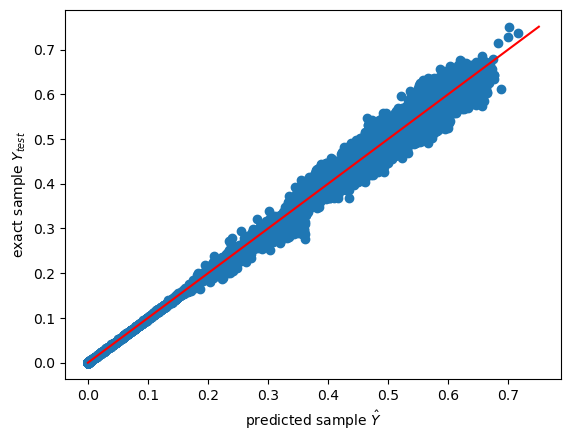

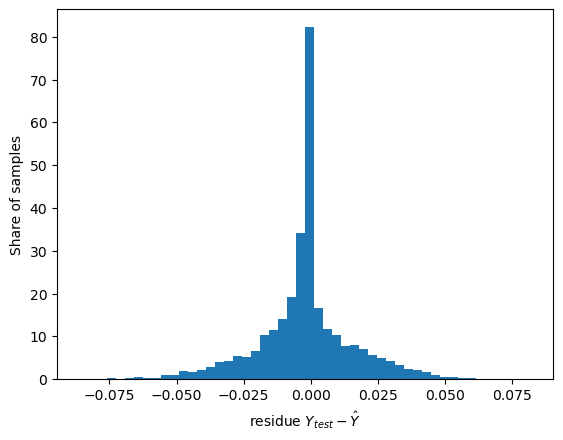

In [62]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, drop_columns=features_weather)

## Section 5.3
We compare the model with the LPJ_Guess output

Comparing LPJ-Guess with our model for the parameter NPP
length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.8492
Accuracy of RandomForestRegressor on test data: -0.5204
MSE for training data 0.1489199913907661
MSE (with sktfct) for test  data 0.1489199913907661
sqrt(MSE) for test data 0.38590153069243727
max error for test data 0.9869299999999999
mean abs error for test data 0.32574499829001363
Comparing LPJ-Guess with our model for the parameter VegC
length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9822
Accuracy of RandomForestRegressor on test data: 0.8743
MSE for training data 4.253002655388911
MSE (with sktfct) for test  data 4.253002655388911
sqrt(MSE) for test data 2.06228093512715
max error for test data 17.074810000000006
mean abs error for test data 1.2696599341655266


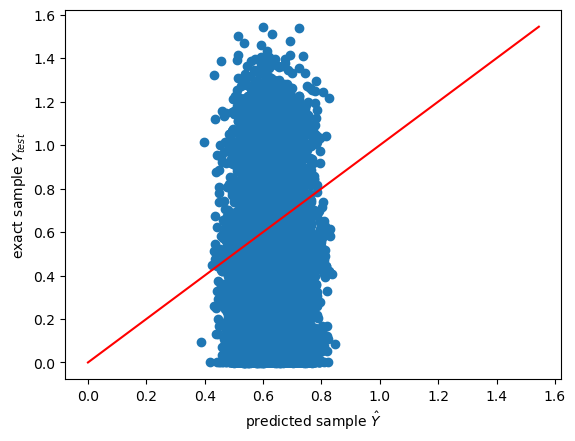

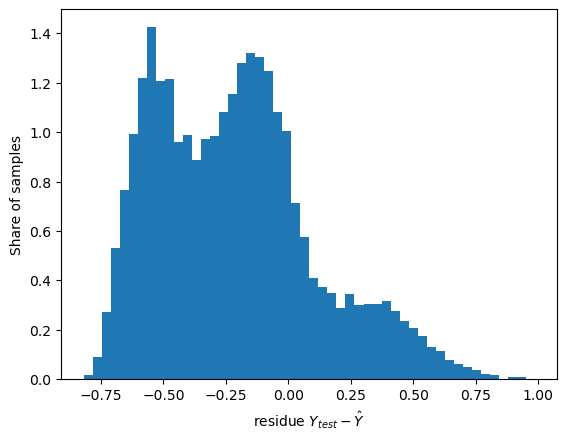

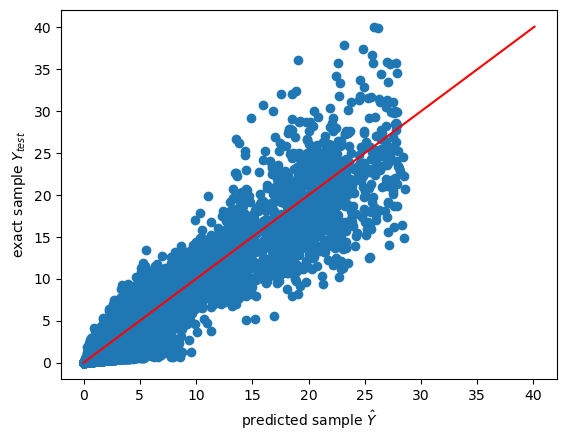

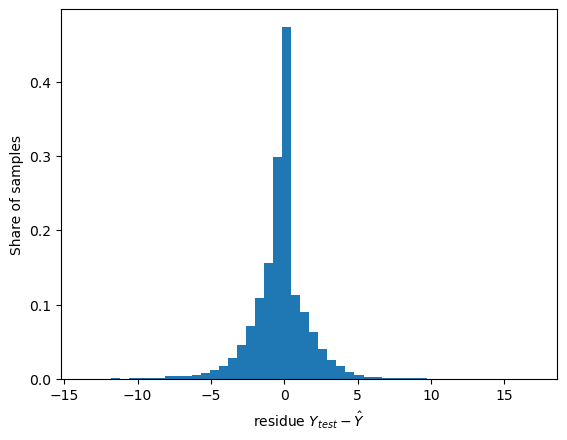

In [63]:
for objective in ['NPP','VegC']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_5, region_test_5, objective=objective, continuous_Y=True, objective_test=f'LPJ_{objective}')